**NETCDF Structure**


In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import glob
import os

def analyze_ncf_structure(file_path):
    """NetCDF file structure"""
    
    print("="*80)
    print(f"ANALYZING: {os.path.basename(file_path)}")
    print("="*80)
    
    with nc.Dataset(file_path, 'r') as ncf:
        
        # 1. GLOBAL ATTRIBUTES
        print("\n1. GLOBAL ATTRIBUTES:")
        print("-" * 40)
        for attr in ncf.ncattrs():
            print(f"{attr}: {getattr(ncf, attr)}")
        
        # 2. DIMENSIONS
        print("\n2. DIMENSIONS:")
        print("-" * 40)
        for dim_name, dim in ncf.dimensions.items():
            print(f"{dim_name}: {len(dim)} ({'unlimited' if dim.isunlimited() else 'fixed'})")
        
        # 3. VARIABLES OVERVIEW
        print("\n3. VARIABLES:")
        print("-" * 40)
        for var_name, var in ncf.variables.items():
            print(f"{var_name}:")
            print(f"  Shape: {var.shape}")
            print(f"  Dimensions: {var.dimensions}")
            print(f"  Data type: {var.dtype}")
            if hasattr(var, 'units'):
                print(f"  Units: {var.units}")
            if hasattr(var, 'long_name'):
                print(f"  Description: {var.long_name}")
            print()
        
        # 4. DETAILED TFLAG 
        print("\n4. TFLAG DETAILED ANALYSIS:")
        print("-" * 40)
        
        if 'TFLAG' in ncf.variables:
            tflag = ncf.variables['TFLAG'][:]
            print(f"TFLAG shape: {tflag.shape}")
            print(f"TFLAG data type: {tflag.dtype}")
            
            print("\nFirst 10 timesteps:")
            for i in range(min(10, tflag.shape[0])):
                date_val = tflag[i, 0, 0]  # Date (YYYYDDD format)
                time_val = tflag[i, 0, 1]  # Time (HHMMSS format)
                
                # Conv. readable format
                year = date_val // 1000
                day_of_year = date_val % 1000
                dt = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
                
                hours = time_val // 10000
                minutes = (time_val % 10000) // 100
                seconds = time_val % 100
                
                dt = dt.replace(hour=hours, minute=minutes, second=seconds)
                
                print(f"  Step {i}: {date_val:07d} {time_val:06d} -> {dt}")
            
            # last 10 timesteps
            if tflag.shape[0] > 10:
                print(f"\nLast 10 timesteps:")
                for i in range(max(0, tflag.shape[0]-10), tflag.shape[0]):
                    date_val = tflag[i, 0, 0]
                    time_val = tflag[i, 0, 1]
                    
                    year = date_val // 1000
                    day_of_year = date_val % 1000
                    dt = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
                    
                    hours = time_val // 10000
                    minutes = (time_val % 10000) // 100
                    seconds = time_val % 100
                    
                    dt = dt.replace(hour=hours, minute=minutes, second=seconds)
                    
                    print(f"  Step {i}: {date_val:07d} {time_val:06d} -> {dt}")
            
            # time step consistency
            print(f"\nTime step analysis:")
            print(f"Total timesteps: {tflag.shape[0]}")
            
            # Calculate time differences
            time_diffs = []
            for i in range(1, min(50, tflag.shape[0])):  # Check first 50 steps
                date1, time1 = tflag[i-1, 0, :]
                date2, time2 = tflag[i, 0, :]
                
                # Convert to datetime
                year1, doy1 = divmod(date1, 1000)
                year2, doy2 = divmod(date2, 1000)
                
                dt1 = datetime(year1, 1, 1) + timedelta(days=doy1-1)
                dt2 = datetime(year2, 1, 1) + timedelta(days=doy2-1)
                
                dt1 = dt1.replace(hour=time1//10000, minute=(time1%10000)//100, second=time1%100)
                dt2 = dt2.replace(hour=time2//10000, minute=(time2%10000)//100, second=time2%100)
                
                diff = (dt2 - dt1).total_seconds() / 3600  # Hours
                time_diffs.append(diff)
            
            if time_diffs:
                print(f"Time step intervals (hours): {set(time_diffs)}")
                print(f"Most common interval: {max(set(time_diffs), key=time_diffs.count)} hours")
        
        # 5. PM2.5 VARIABLE 
        print("\n5. PM2.5 VARIABLE ANALYSIS:")
        print("-" * 40)
        
        pm25_vars = [var for var in ncf.variables.keys() if 'PM25' in var.upper()]
        print(f"PM2.5 variables found: {pm25_vars}")
        
        for var_name in pm25_vars:
            var = ncf.variables[var_name]
            print(f"\n{var_name}:")
            print(f"  Shape: {var.shape}")
            print(f"  Dimensions: {var.dimensions}")
            if hasattr(var, 'units'):
                print(f"  Units: {var.units}")
            if hasattr(var, 'long_name'):
                print(f"  Description: {var.long_name}")
            
            # data statistics
            if var.size > 0:
                data_sample = var[0, 0, :, :] if len(var.shape) == 4 else var[0, :, :]
                valid_data = data_sample[~np.isnan(data_sample)]
                if len(valid_data) > 0:
                    print(f"  Sample timestep stats:")
                    print(f"    Min: {valid_data.min():.3f}")
                    print(f"    Max: {valid_data.max():.3f}")
                    print(f"    Mean: {valid_data.mean():.3f}")

def compare_multiple_files(file_pattern):
    """Compare structure across multiple files"""
    
    print("\n" + "="*80)
    print("MULTI-FILE COMPARISON")
    print("="*80)
    
    files = sorted(glob.glob(file_pattern))[:5]  # First 5 files
    
    print(f"Found {len(glob.glob(file_pattern))} total files")
    print(f"Analyzing first 5 files:")
    
    for i, file_path in enumerate(files):
        print(f"\n{i+1}. {os.path.basename(file_path)}")
        
        with nc.Dataset(file_path, 'r') as ncf:
            # Check TFLAG range
            if 'TFLAG' in ncf.variables:
                tflag = ncf.variables['TFLAG'][:]
                
                # First timestep
                date1, time1 = tflag[0, 0, :]
                year1, doy1 = divmod(date1, 1000)
                dt1 = datetime(year1, 1, 1) + timedelta(days=doy1-1)
                dt1 = dt1.replace(hour=time1//10000, minute=(time1%10000)//100)
                
                # Last timestep
                date2, time2 = tflag[-1, 0, :]
                year2, doy2 = divmod(date2, 1000)
                dt2 = datetime(year2, 1, 1) + timedelta(days=doy2-1)
                dt2 = dt2.replace(hour=time2//10000, minute=(time2%10000)//100)
                
                print(f"   TFLAG range: {dt1} to {dt2}")
                print(f"   Timesteps: {tflag.shape[0]}")
                
                # Check PM25 variables
                pm25_vars = [var for var in ncf.variables.keys() if 'PM25' in var.upper()]
                print(f"   PM2.5 vars: {pm25_vars}")

### ANALYSIS:

import xarray as xr
import numpy as np
import pandas as pd
import glob
import os

def analyze_ncf_structure_xarray(file_path):
    """Analyze NetCDF file structure using xarray (like your code)"""
    print(f"=== ANALYZING: {os.path.basename(file_path)} ===\n")
    
    ds = xr.open_dataset(file_path)
    
    # 1. File attributes
    print("GLOBAL ATTRIBUTES:")
    for attr, value in ds.attrs.items():
        print(f"  {attr}: {value}")
    
    # 2. Dimensions
    print(f"\nDIMENSIONS:")
    for dim, size in ds.dims.items():
        print(f"  {dim}: {size}")
    
    # 3. Variables overview
    print(f"\nVARIABLES:")
    for var_name, var in ds.variables.items():
        print(f"  {var_name}:")
        print(f"    Shape: {var.shape}")
        print(f"    Dims: {var.dims}")
        print(f"    Dtype: {var.dtype}")
        if hasattr(var, 'attrs'):
            for attr, value in var.attrs.items():
                print(f"    {attr}: {value}")
        print()
    
    # 4. TFLAG detailed analysis
    if 'TFLAG' in ds.variables:
        print("TFLAG DETAILED ANALYSIS:")
        tflag = ds['TFLAG']
        print(f"  TFLAG shape: {tflag.shape}")
        print(f"  TFLAG dims: {tflag.dims}")
        
        # Show first 20 time steps 
        print(f"\n  FIRST 20 TIME STEPS:")
        print("  Step | Date (YYYYDDD) | Time (HHMMSS) | Converted DateTime")
        print("  -----|----------------|---------------|-------------------")
        
        max_steps = min(20, ds.dims['TSTEP'])
        for t in range(max_steps):
            # Get first variable's TFLAG (usually all variables have same time)
            tflag_values = tflag.isel(TSTEP=t, VAR=0).values
            date_val = int(tflag_values[0])
            time_val = int(tflag_values[1])
            
            # Convert to datetime
            try:
                year = date_val // 1000
                day_of_year = date_val % 1000
                base_date = pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1)
                
                time_str = f"{time_val:06d}"
                hour = int(time_str[:2])
                minute = int(time_str[2:4])
                second = int(time_str[4:6])
                
                final_datetime = base_date + pd.Timedelta(hours=hour, minutes=minute, seconds=second)
                
                print(f"  {t:4d} | {date_val:11d} | {time_val:11d} | {final_datetime}")
            except Exception as e:
                print(f"  {t:4d} | {date_val:11d} | {time_val:11d} | ERROR: {e}")
        
        # Check time intervals
        print(f"\n  TIME INTERVAL ANALYSIS:")
        if ds.dims['TSTEP'] > 1:
            intervals = []
            for t in range(1, min(10, ds.dims['TSTEP'])):
                tflag1 = tflag.isel(TSTEP=t-1, VAR=0).values
                tflag2 = tflag.isel(TSTEP=t, VAR=0).values
                
                # Convert both to datetime
                date1, time1 = int(tflag1[0]), int(tflag1[1])
                date2, time2 = int(tflag2[0]), int(tflag2[1])
                
                year1, doy1 = divmod(date1, 1000)
                year2, doy2 = divmod(date2, 1000)
                
                dt1 = pd.to_datetime(f"{year1}-01-01") + pd.Timedelta(days=doy1-1)
                dt2 = pd.to_datetime(f"{year2}-01-01") + pd.Timedelta(days=doy2-1)
                
                dt1 += pd.Timedelta(hours=time1//10000, minutes=(time1%10000)//100, seconds=time1%100)
                dt2 += pd.Timedelta(hours=time2//10000, minutes=(time2%10000)//100, seconds=time2%100)
                
                interval_hours = (dt2 - dt1).total_seconds() / 3600
                intervals.append(interval_hours)
            
            if intervals:
                unique_intervals = list(set(intervals))
                print(f"    Time intervals found: {unique_intervals} hours")
                print(f"    Most common interval: {max(set(intervals), key=intervals.count)} hours")
    
    # 5. PM2.5 variable analysis
    pm25_vars = [var for var in ds.variables if 'PM25' in var.upper()]
    if pm25_vars:
        print(f"\nPM2.5 VARIABLE ANALYSIS:")
        for var_name in pm25_vars:
            var = ds[var_name]
            print(f"  {var_name}:")
            print(f"    Shape: {var.shape}")
            print(f"    Dims: {var.dims}")
            print(f"    Min: {var.min().values:.3f}")
            print(f"    Max: {var.max().values:.3f}")
            print(f"    Mean: {var.mean().values:.3f}")
            
            # Sample values from first time step
            if len(var.shape) >= 3:
                sample_data = var.isel(TSTEP=0)
                if 'LAY' in var.dims:
                    sample_data = sample_data.isel(LAY=0)
                print(f"    Sample (t=0): shape={sample_data.shape}")
                print(f"    Sample stats: min={sample_data.min().values:.3f}, max={sample_data.max().values:.3f}")
    
    ds.close()
    return True

# RUN ANALYSIS ON YOUR FILES
ctm_dir = r"C:\Users\priom\Downloads\test_pm25\pm25_data\2024"
all_files = sorted(glob.glob(os.path.join(ctm_dir, "*.ncf")))

print("="*80)
print("ANALYZING YOUR NetCDF FILES")
print("="*80)

print(f"Looking in: {ctm_dir}")
print(f"Found {len(all_files)} .ncf files")

if len(all_files) > 0:
    print("\nFirst 5 files:")
    for i, f in enumerate(all_files[:5]):
        print(f"  {i}: {os.path.basename(f)}")
    
    print(f"\n{'='*60}")
    print("DETAILED ANALYSIS OF FIRST FILE:")
    print(f"{'='*60}")
    
    # Analyze first file in detail
    analyze_ncf_structure_xarray(all_files[0])
    
    print(f"\n{'='*60}")
    print("QUICK COMPARISON OF FIRST 3 FILES:")
    print(f"{'='*60}")
    
    # Quick comparison
    for i, file_path in enumerate(all_files[:3]):
        print(f"\nFILE {i+1}: {os.path.basename(file_path)}")
        try:
            ds = xr.open_dataset(file_path)
            print(f"  TSTEP dimension: {ds.dims.get('TSTEP', 'N/A')}")
            print(f"  SDATE: {ds.attrs.get('SDATE', 'N/A')}")
            print(f"  STIME: {ds.attrs.get('STIME', 'N/A')}")
            
            if 'TFLAG' in ds.variables:
                first_tflag = ds['TFLAG'].isel(TSTEP=0, VAR=0).values
                last_tflag = ds['TFLAG'].isel(TSTEP=-1, VAR=0).values
                print(f"  First TFLAG: [{int(first_tflag[0])}, {int(first_tflag[1])}]")
                print(f"  Last TFLAG:  [{int(last_tflag[0])}, {int(last_tflag[1])}]")
            
            pm25_vars = [var for var in ds.variables if 'PM25' in var.upper()]
            print(f"  PM2.5 variables: {pm25_vars}")
            
            ds.close()
        except Exception as e:
            print(f"  Error: {e}")
            
else:
    print("ERROR: No .ncf files found!")
  

ANALYZING YOUR NetCDF FILES
Looking in: C:\Users\priom\Downloads\test_pm25\pm25_data\2024
Found 339 .ncf files

First 5 files:
  0: PM25_L01_24hr_20240106.ncf
  1: PM25_L01_24hr_20240107.ncf
  2: PM25_L01_24hr_20240108.ncf
  3: PM25_L01_24hr_20240109.ncf
  4: PM25_L01_24hr_20240110.ncf

DETAILED ANALYSIS OF FIRST FILE:
=== ANALYZING: PM25_L01_24hr_20240106.ncf ===

GLOBAL ATTRIBUTES:
  IOAPI_VERSION: $Id: @(#) ioapi library version 3.0 $                                           
  EXEC_ID: ????????????????                                                                
  FTYPE: 1
  CDATE: 2024007
  CTIME: 110205
  WDATE: 2024007
  WTIME: 110205
  SDATE: 2024006
  STIME: 90000
  TSTEP: 10000
  NTHIK: 1
  NCOLS: 285
  NROWS: 258
  NLAYS: 1
  NVARS: 1
  GDTYP: 2
  P_ALP: 30.0
  P_BET: 60.0
  P_GAM: -121.0
  XCENT: -121.0
  YCENT: 49.0
  XORIG: -342000.0
  YORIG: -942000.0
  XCELL: 4000.0
  YCELL: 4000.0
  VGTYP: 7
  VGTOP: 5000.0
  VGLVLS: [1.    0.995]
  GDNAM: AIRPACT_04km    
  UPNAM:

**TIME SERIES**

Loading grid from: PM25_L01_24hr_20240106.ncf
CTM grid: 258 x 285 cells
Grid resolution: 4.0 km x 4.0 km
Converting all grid points to lat/lon...
Calculating distances to target: (47.120000, -118.382000)

Nearest CTM grid point found:
  Grid indices: row 185, col 133
  Grid coordinates: (47.109762, -118.373052)
  Distance from target: 1.509 km

Nearby grid points (within 2 cells):
    row 183, col 131: (47.037708, -118.485871) - 14.710 km
    row 183, col 132: (47.036526, -118.431253) - 10.758 km
    row 183, col 133: (47.035319, -118.376637) - 9.418 km
    row 183, col 134: (47.034086, -118.322024) - 11.630 km
    row 183, col 135: (47.032828, -118.267414) - 15.981 km
    row 184, col 131: (47.074931, -118.484154) - 12.394 km
    row 184, col 132: (47.073749, -118.429499) - 7.359 km
    row 184, col 133: (47.072540, -118.374846) - 5.328 km
    row 184, col 134: (47.071307, -118.320196) - 8.734 km
    row 184, col 135: (47.070048, -118.265548) - 14.065 km
    row 185, col 131: (47.1121

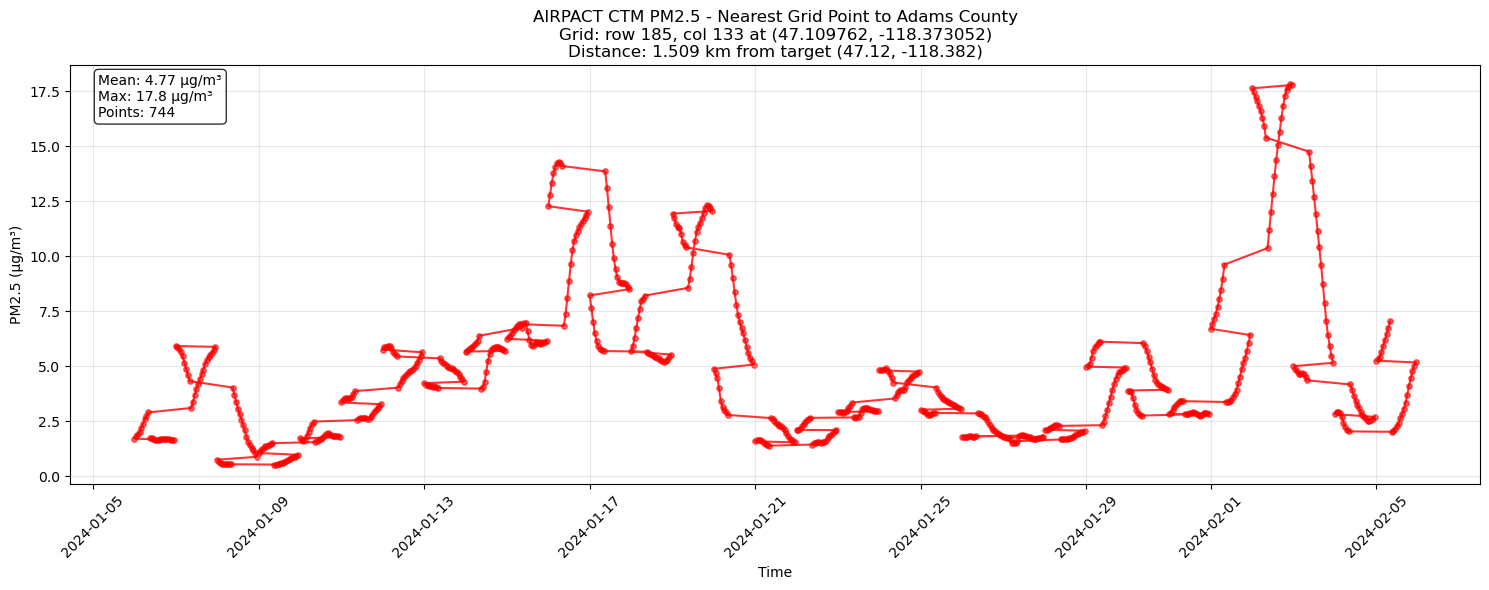


Sample extracted data:
             datetime  pm25_ctm   grid_lat    grid_lon  distance_km
0 2024-01-06 09:00:00  1.731218  47.109762 -118.373052     1.509276
1 2024-01-06 10:00:00  1.733927  47.109762 -118.373052     1.509276
2 2024-01-06 11:00:00  1.702549  47.109762 -118.373052     1.509276
3 2024-01-06 12:00:00  1.676180  47.109762 -118.373052     1.509276
4 2024-01-06 13:00:00  1.675238  47.109762 -118.373052     1.509276


In [8]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime, timedelta


# Coordinates (Adams County EPA site: Ritzville School District, Washington )
target_lat = 47.120
target_lon = -118.382

# Load first CTM file to get grid information
ctm_dir = r"C:\Users\priom\Downloads\test_pm25\pm25_data\2024"
all_files = sorted(glob.glob(os.path.join(ctm_dir, "*.ncf")))
first_file = all_files[0]

print(f"Loading grid from: {os.path.basename(first_file)}")

ds = xr.open_dataset(first_file)

# Get grid coordinates
xorig = ds.attrs['XORIG']
yorig = ds.attrs['YORIG'] 
xcell = ds.attrs['XCELL']
ycell = ds.attrs['YCELL']
nrows = ds.attrs['NROWS']
ncols = ds.attrs['NCOLS']

print(f"CTM grid: {nrows} x {ncols} cells")
print(f"Grid resolution: {xcell/1000:.1f} km x {ycell/1000:.1f} km")

# Create coordinate arrays
x_proj = np.arange(ncols) * xcell + xorig + xcell/2
y_proj = np.arange(nrows) * ycell + yorig + ycell/2
X_proj, Y_proj = np.meshgrid(x_proj, y_proj)

# Lambert Conformal Conic to lat/lon conversion
def lcc_to_latlon(x, y, lon0=-121.0, lat0=49.0, lat1=30.0, lat2=60.0):
    lon0_r = np.radians(lon0)
    lat0_r = np.radians(lat0)
    lat1_r = np.radians(lat1)
    lat2_r = np.radians(lat2)
    
    R = 6371000.0
    n = np.log(np.cos(lat1_r) / np.cos(lat2_r)) / np.log(np.tan(np.pi/4 + lat2_r/2) / np.tan(np.pi/4 + lat1_r/2))
    F = np.cos(lat1_r) * (np.tan(np.pi/4 + lat1_r/2)**n) / n
    rho0 = R * F / (np.tan(np.pi/4 + lat0_r/2)**n)
    
    rho = np.sqrt(x**2 + (rho0 - y)**2)
    theta = np.arctan2(x, rho0 - y)
    
    lat = 2 * np.arctan((R * F / rho)**(1/n)) - np.pi/2
    lon = lon0_r + theta / n
    
    return np.degrees(lon), np.degrees(lat)

# Convert ALL grid points to lat/lon
print("Converting all grid points to lat/lon...")
grid_lons, grid_lats = lcc_to_latlon(X_proj, Y_proj)

# Calculate distances from target to ALL grid points
print(f"Calculating distances to target: ({target_lat:.6f}, {target_lon:.6f})")

# Distance in degrees (approximate)
distances = np.sqrt((grid_lats - target_lat)**2 + (grid_lons - target_lon)**2)

# Find minimum distance location
min_idx = np.unravel_index(np.argmin(distances), distances.shape)
best_row, best_col = min_idx

# Convert distance to km (approximate: 1 degree ≈ 111 km)
min_distance_km = distances[best_row, best_col] * 111

print(f"\nNearest CTM grid point found:")
print(f"  Grid indices: row {best_row}, col {best_col}")
print(f"  Grid coordinates: ({grid_lats[best_row, best_col]:.6f}, {grid_lons[best_row, best_col]:.6f})")
print(f"  Distance from target: {min_distance_km:.3f} km")

# Show nearby alternatives for comparison
print(f"\nNearby grid points (within 2 cells):")
for dr in [-2, -1, 0, 1, 2]:
    for dc in [-2, -1, 0, 1, 2]:
        r = best_row + dr
        c = best_col + dc
        if 0 <= r < nrows and 0 <= c < ncols:
            dist_km = distances[r, c] * 111
            marker = " ← SELECTED" if (r == best_row and c == best_col) else ""
            print(f"    row {r:3d}, col {c:3d}: ({grid_lats[r,c]:.6f}, {grid_lons[r,c]:.6f}) - {dist_km:.3f} km{marker}")

ds.close()

# Extract time series from the exact nearest grid point
print(f"\n=== EXTRACTING DATA FROM NEAREST GRID POINT ===")

january_files = all_files[:31]
ctm_data = []

for i, file_path in enumerate(january_files):
    if i % 5 == 0:
        print(f"Processing file {i+1}/{len(january_files)}: {os.path.basename(file_path)}")
    
    try:
        ds = xr.open_dataset(file_path)
        
        # Extract date from TFLAG
        first_tflag = ds['TFLAG'].isel(TSTEP=0, VAR=0).values
        date_str = str(first_tflag[0])
        year = int(date_str[:4])
        day_of_year = int(date_str[4:])
        file_date = pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1)
        
        # Process each time step
        for t in range(ds.dims['TSTEP']):
            time_flag = ds['TFLAG'].isel(TSTEP=t, VAR=0).values
            time_str = str(time_flag[1]).zfill(6)
            hour = int(time_str[:2])
            minute = int(time_str[2:4])
            
            timestamp = file_date + timedelta(hours=hour, minutes=minute)
            
            # Extract PM2.5 value from the exact nearest grid point
            pm25_value = ds['RollingA24_PM25'].isel(
                TSTEP=t, LAY=0, ROW=best_row, COL=best_col
            ).values
            
            if np.isfinite(pm25_value):
                ctm_data.append({
                    'datetime': timestamp,
                    'pm25_ctm': float(pm25_value),
                    'grid_row': best_row,
                    'grid_col': best_col,
                    'grid_lat': grid_lats[best_row, best_col],
                    'grid_lon': grid_lons[best_row, best_col],
                    'distance_km': min_distance_km
                })
        
        ds.close()
        
    except Exception as e:
        print(f"  Error processing {file_path}: {e}")
        continue

# Create dataframe
ctm_df = pd.DataFrame(ctm_data)
print(f"\nExtracted {len(ctm_df)} CTM data points from nearest grid point")
print(f"Time range: {ctm_df['datetime'].min()} to {ctm_df['datetime'].max()}")
print(f"PM2.5 statistics:")
print(f"  Mean: {ctm_df['pm25_ctm'].mean():.2f} μg/m³")
print(f"  Min: {ctm_df['pm25_ctm'].min():.2f} μg/m³")
print(f"  Max: {ctm_df['pm25_ctm'].max():.2f} μg/m³")
print(f"  Std: {ctm_df['pm25_ctm'].std():.2f} μg/m³")

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(ctm_df['datetime'], ctm_df['pm25_ctm'], 'r-', linewidth=1.5, alpha=0.8)
plt.scatter(ctm_df['datetime'], ctm_df['pm25_ctm'], c='red', s=15, alpha=0.6)

plt.title(f'AIRPACT CTM PM2.5 - Nearest Grid Point to Adams County\n' + 
          f'Grid: row {best_row}, col {best_col} at ({grid_lats[best_row, best_col]:.6f}, {grid_lons[best_row, best_col]:.6f})\n' +
          f'Distance: {min_distance_km:.3f} km from target ({target_lat}, {target_lon})', fontsize=12)
plt.xlabel('Time')
plt.ylabel('PM2.5 (μg/m³)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add statistics
plt.text(0.02, 0.98, f'Mean: {ctm_df["pm25_ctm"].mean():.2f} μg/m³\nMax: {ctm_df["pm25_ctm"].max():.1f} μg/m³\nPoints: {len(ctm_df)}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('airpact_exact_nearest_grid.png', dpi=300, bbox_inches='tight')
plt.show()

# Show sample data
print(f"\nSample extracted data:")
print(ctm_df[['datetime', 'pm25_ctm', 'grid_lat', 'grid_lon', 'distance_km']].head())

PM2.5 ANIMATION CREATOR WITH DISPLAY
STEP 1: Creating preview frame...

CREATING PREVIEW FRAME
Preview file: PM25_L01_24hr_20240121.ncf


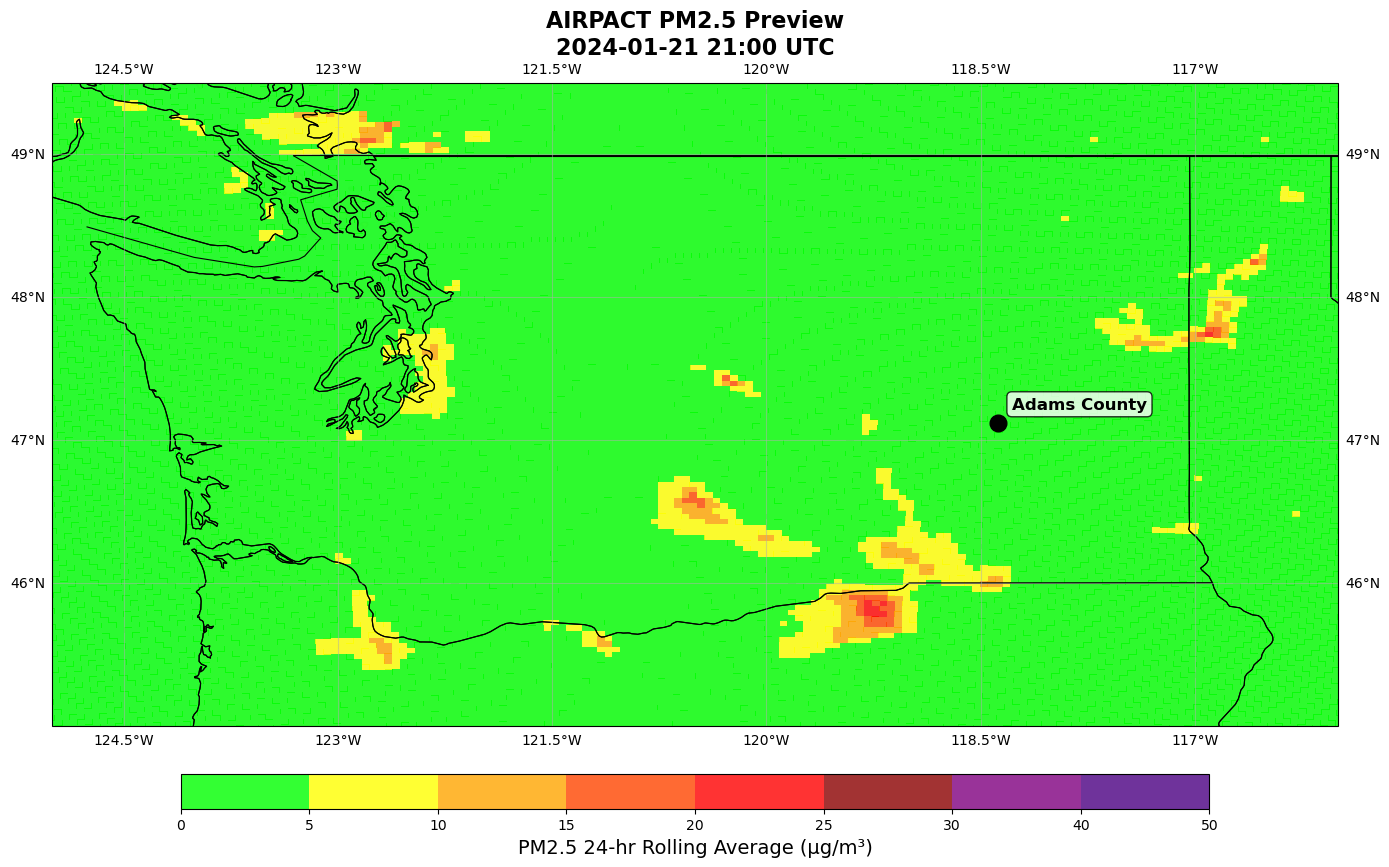


Preview Statistics:
   Timestamp: 2024-01-21 21:00:00
   PM2.5 Range: 0.0 - 30.5 μg/m³
   Mean: 1.6 μg/m³



Press Enter to continue with full animation creation... 



STEP 2: CREATING HOURLY PM2.5 ANIMATION
Settings:
- ~744 frames (every hour of January)
- Display every 24th frame during creation
- Auto-display final GIF when complete
- Expected file size: 50-150 MB
- Processing time: 10-30 minutes
=== CREATING PM2.5 ANIMATION ===
Found 31 January files
Grid: 258 x 285, Cell size: 4.0 km
Determining data range...
Color scale: 0 to 4.5 μg/m³

Creating animation frames...
Processing file 1/31: PM25_L01_24hr_20240106.ncf


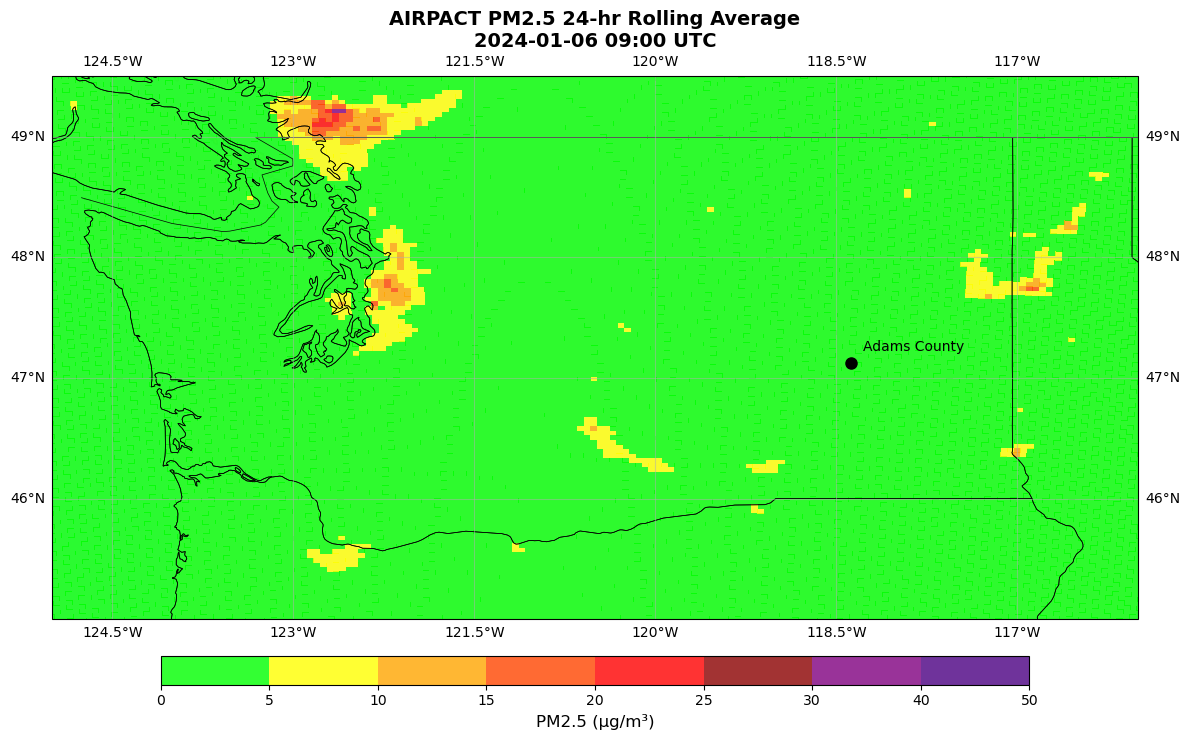

  Created 24 frames...
Processing file 2/31: PM25_L01_24hr_20240107.ncf


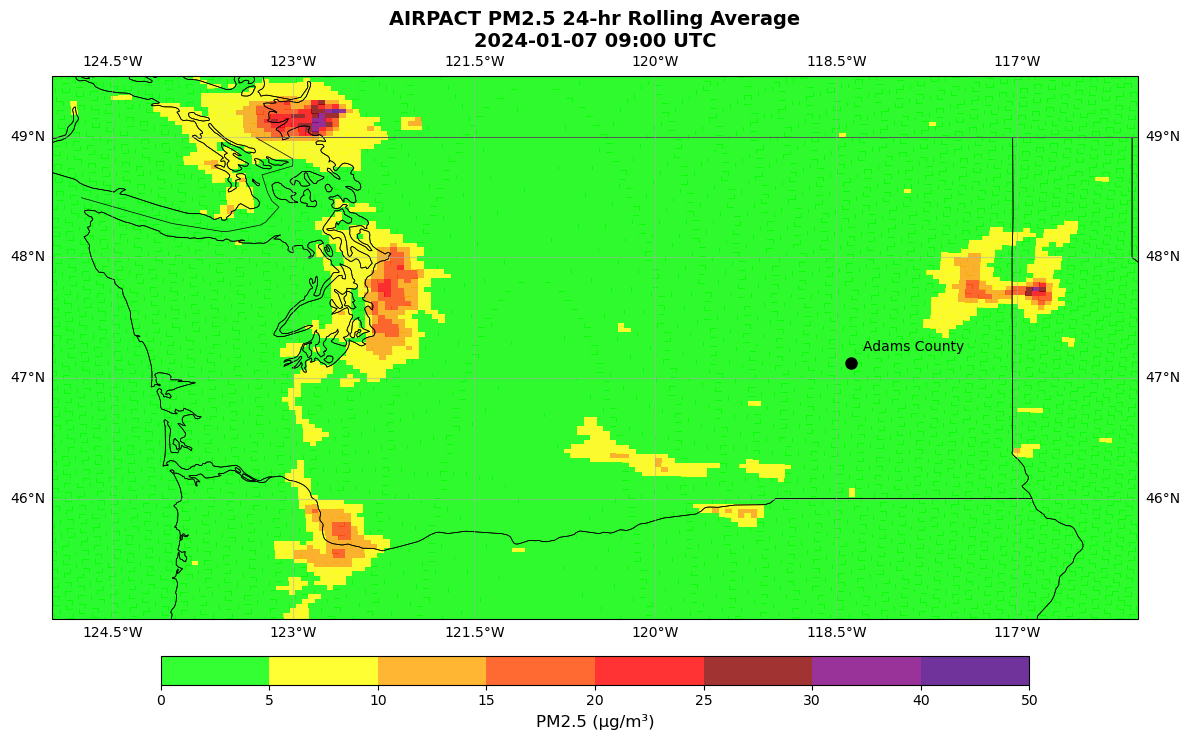

  Created 48 frames...
Processing file 3/31: PM25_L01_24hr_20240108.ncf


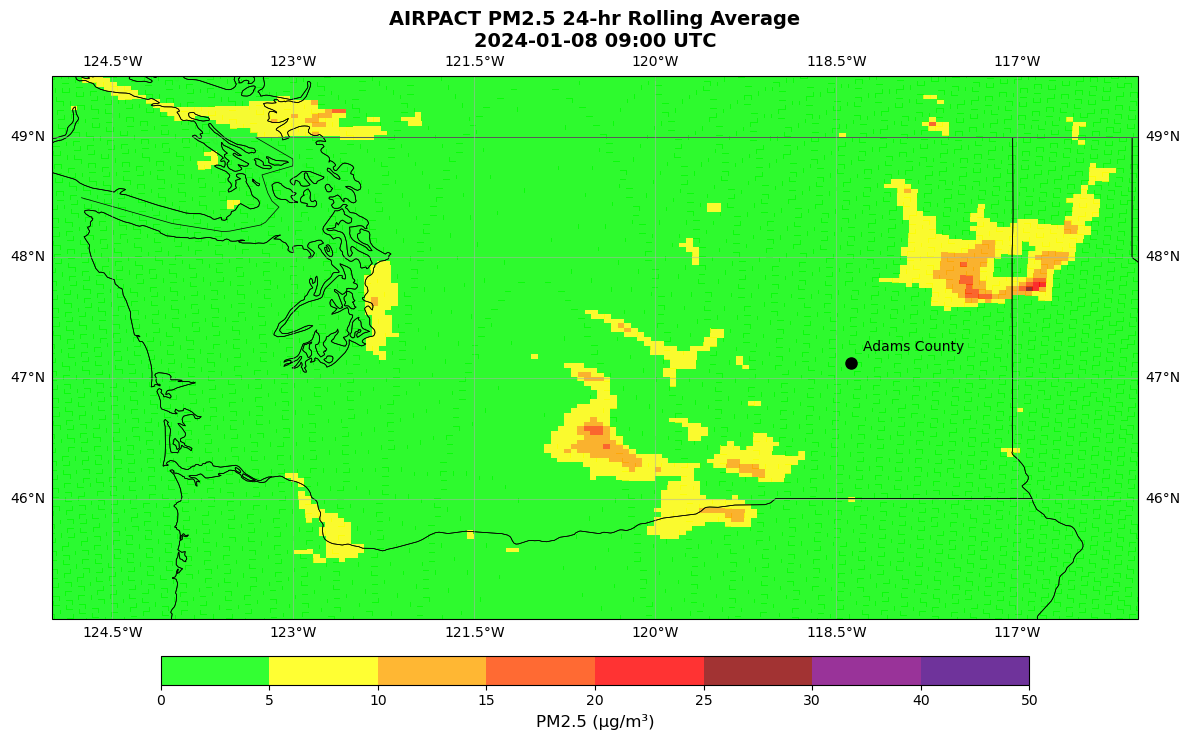

  Created 72 frames...
Processing file 4/31: PM25_L01_24hr_20240109.ncf


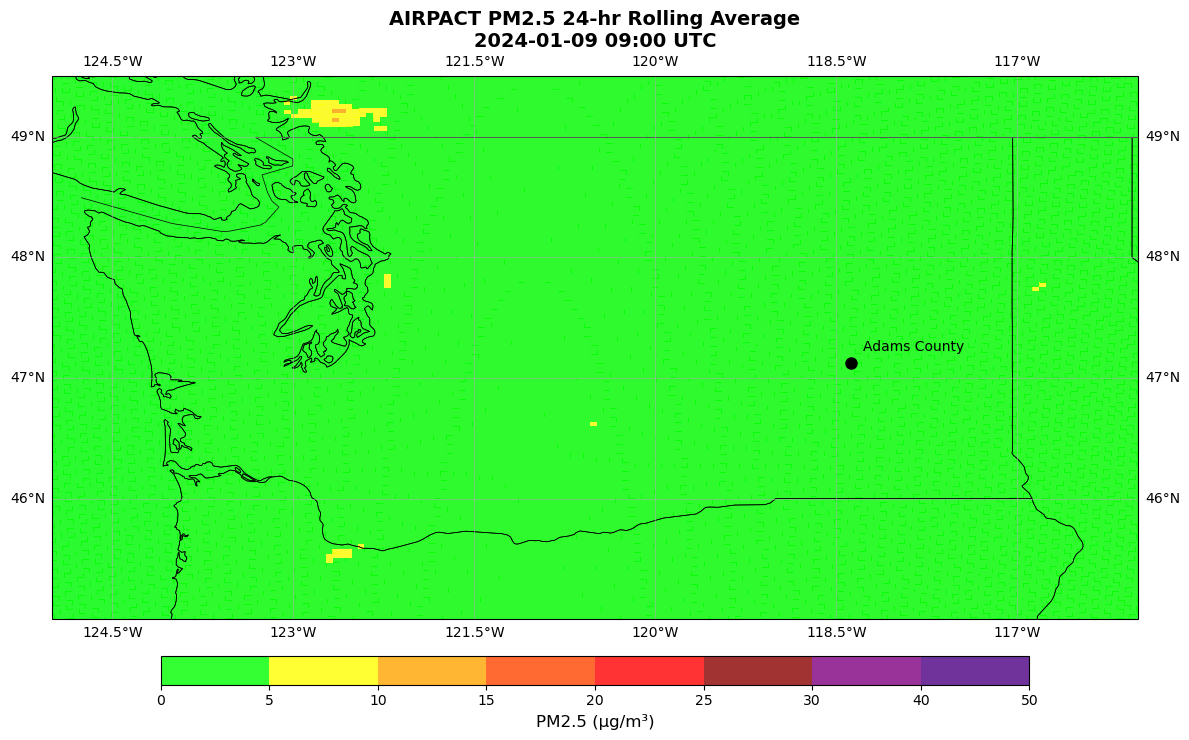

  Created 96 frames...
Processing file 5/31: PM25_L01_24hr_20240110.ncf


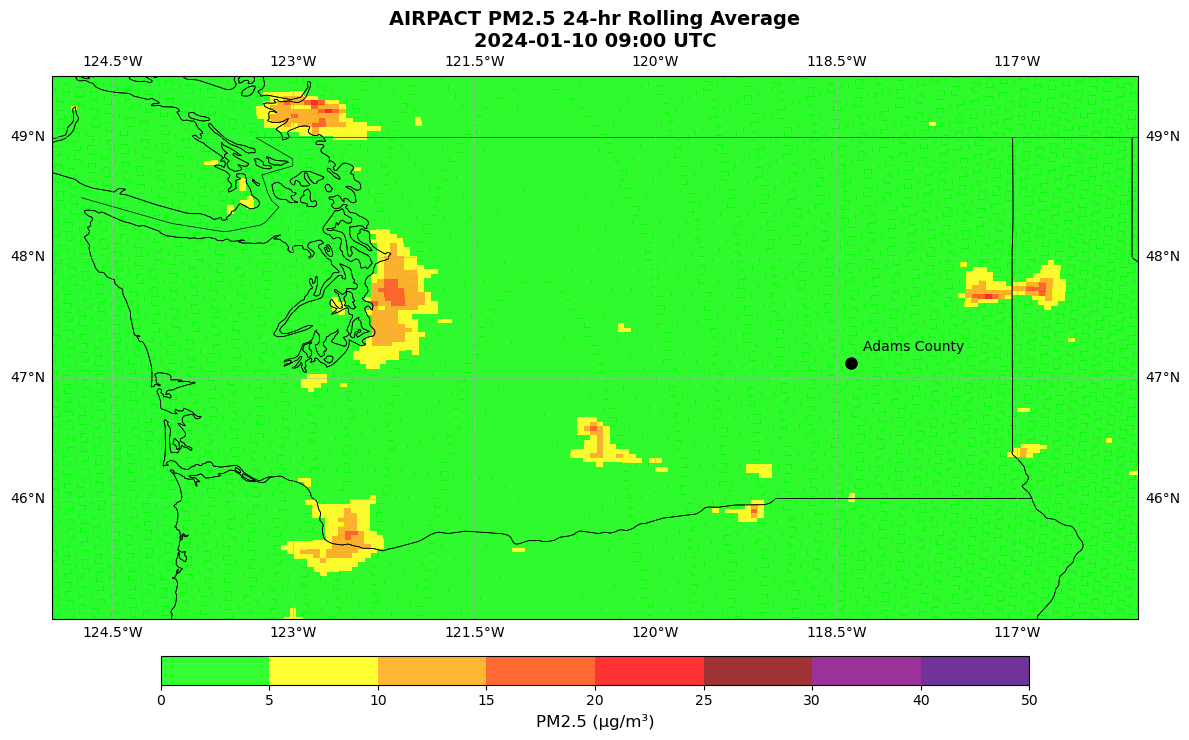

  Created 120 frames...
Processing file 6/31: PM25_L01_24hr_20240111.ncf


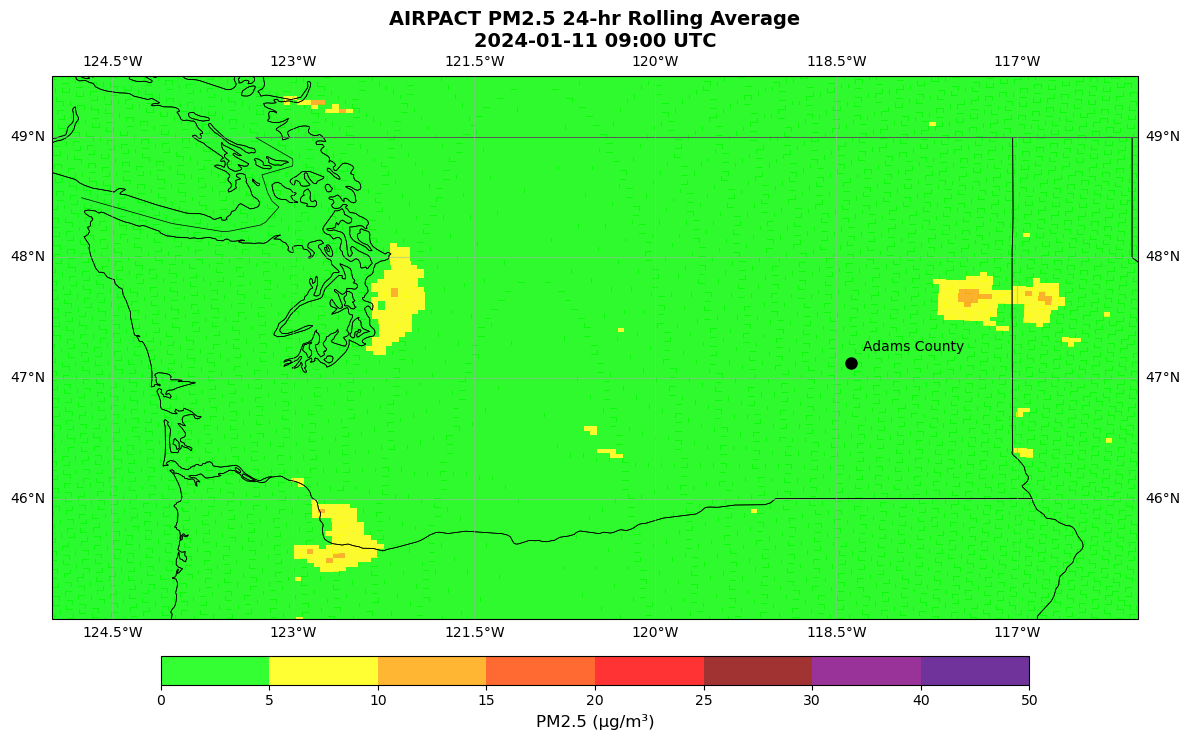

  Created 144 frames...
Processing file 7/31: PM25_L01_24hr_20240112.ncf


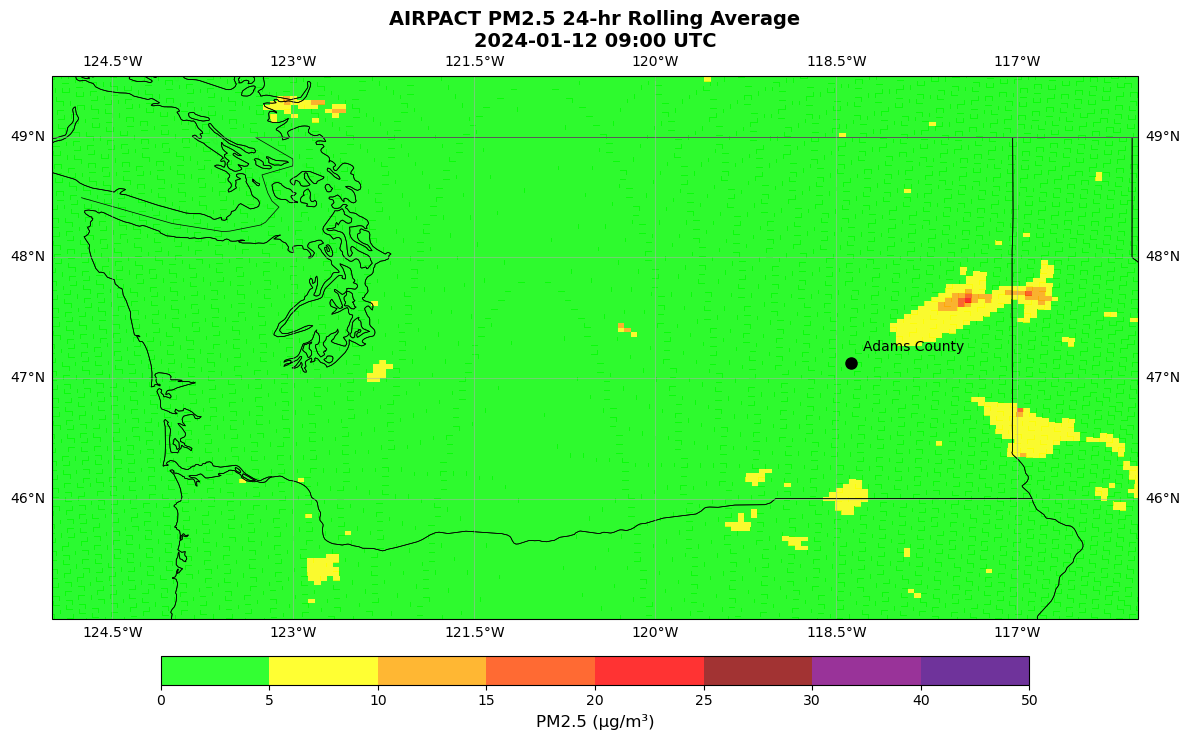

  Created 168 frames...
Processing file 8/31: PM25_L01_24hr_20240113.ncf


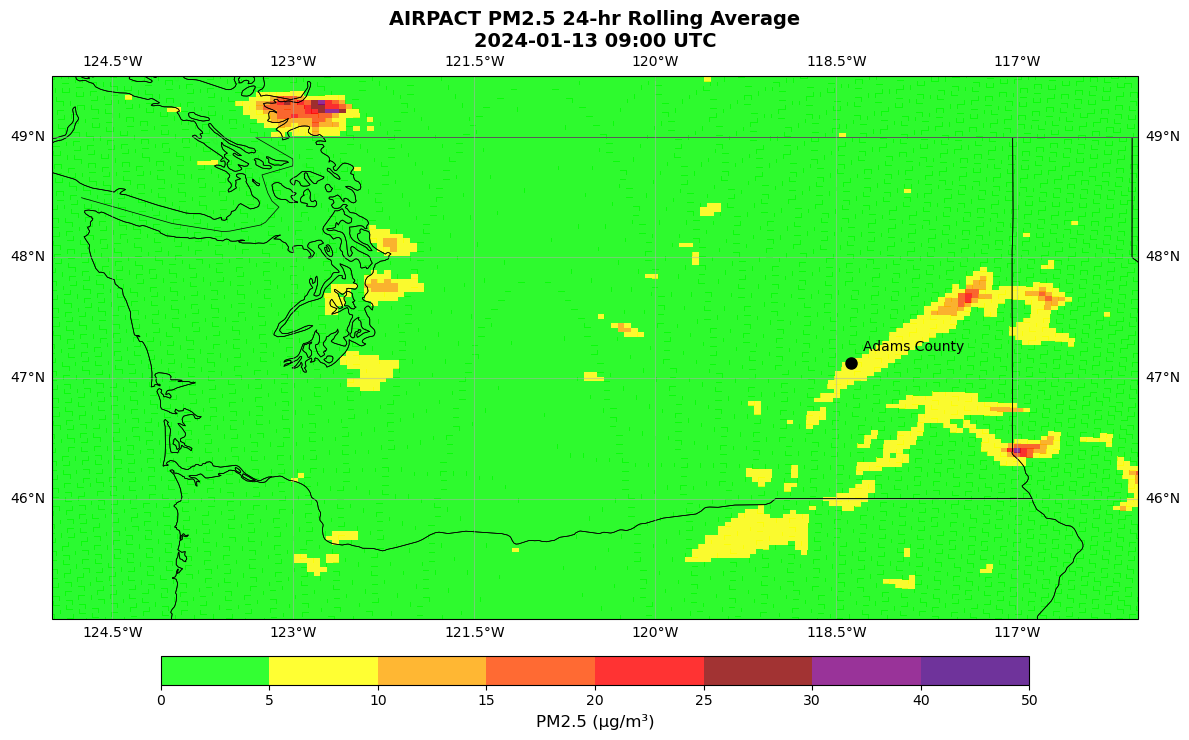

  Created 192 frames...
Processing file 9/31: PM25_L01_24hr_20240114.ncf


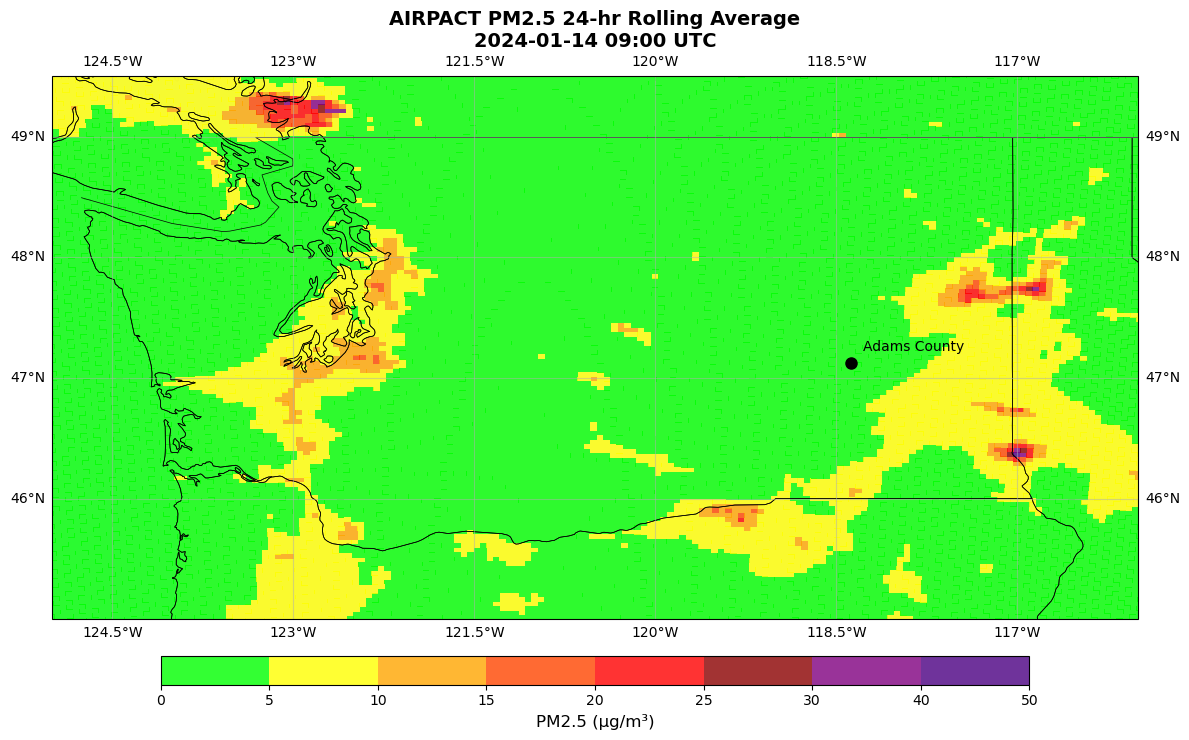

  Created 216 frames...
Processing file 10/31: PM25_L01_24hr_20240115.ncf


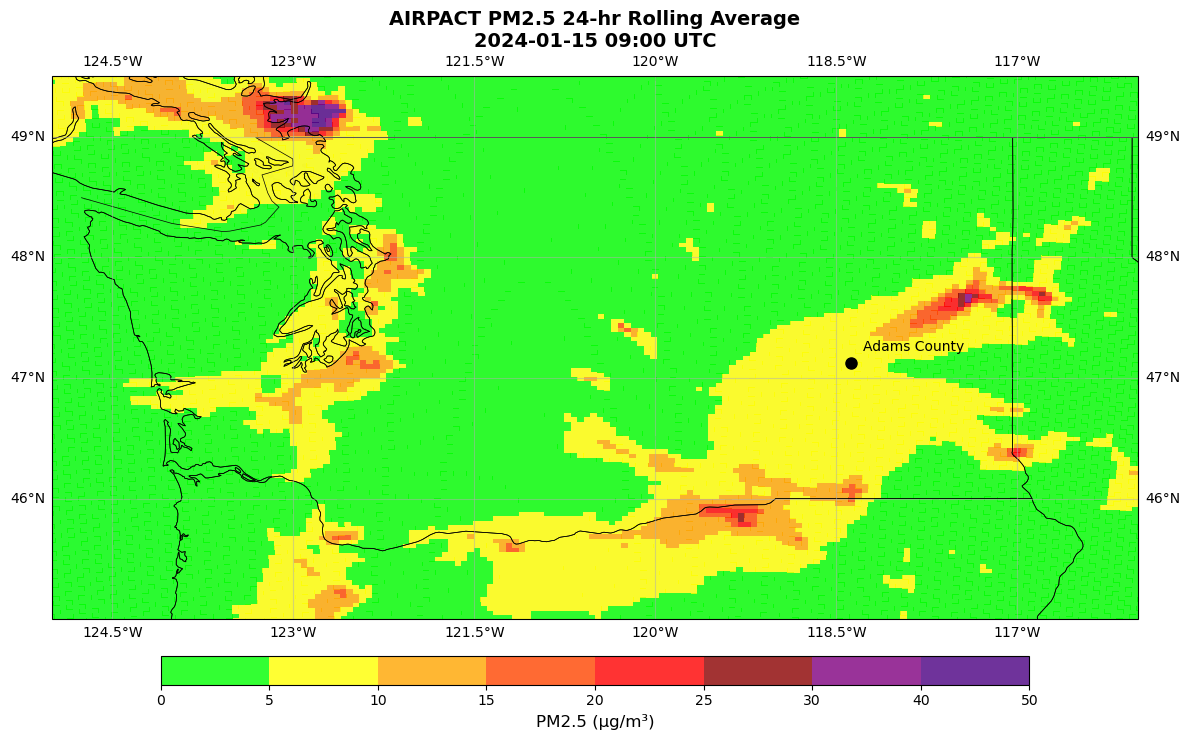

  Created 240 frames...
Processing file 11/31: PM25_L01_24hr_20240116.ncf


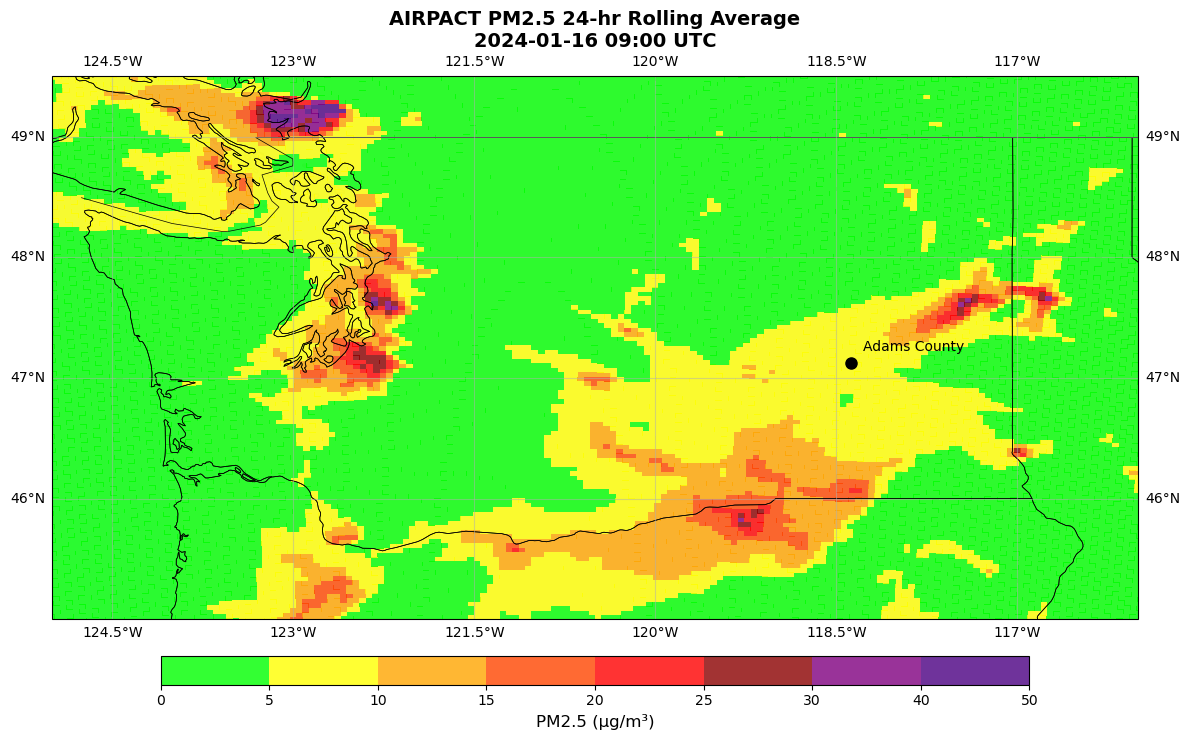

  Created 264 frames...
Processing file 12/31: PM25_L01_24hr_20240117.ncf


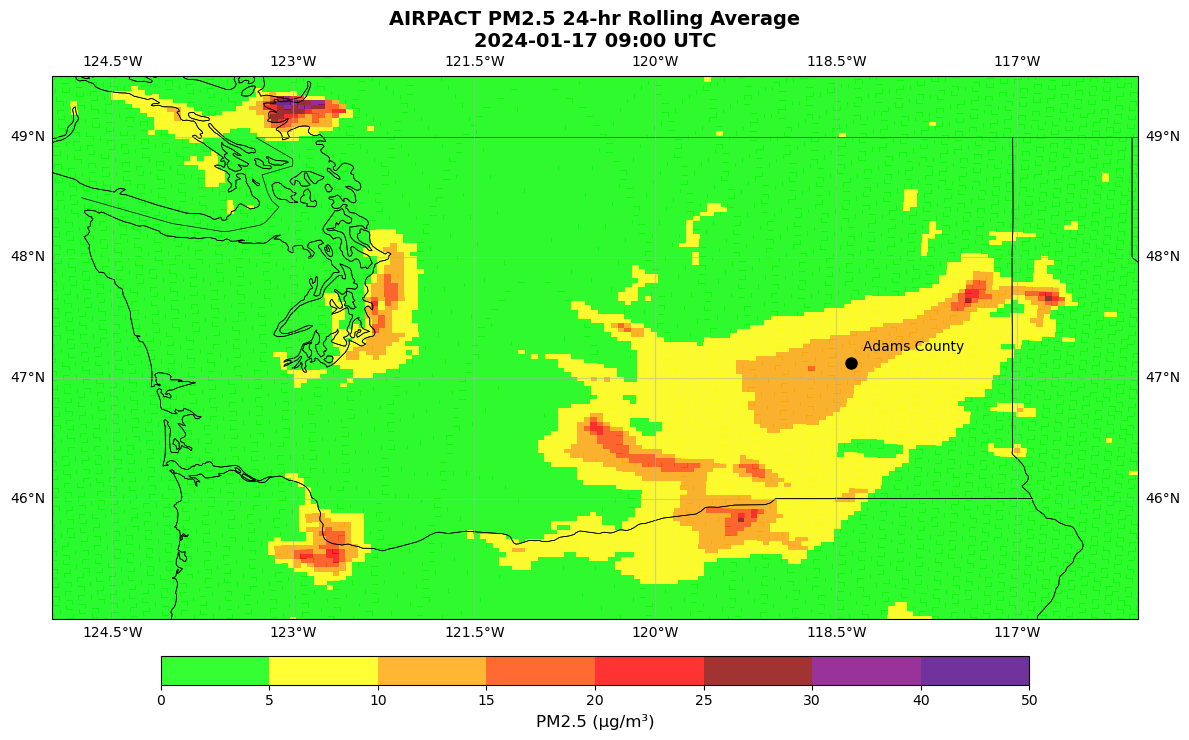

  Created 288 frames...
Processing file 13/31: PM25_L01_24hr_20240118.ncf


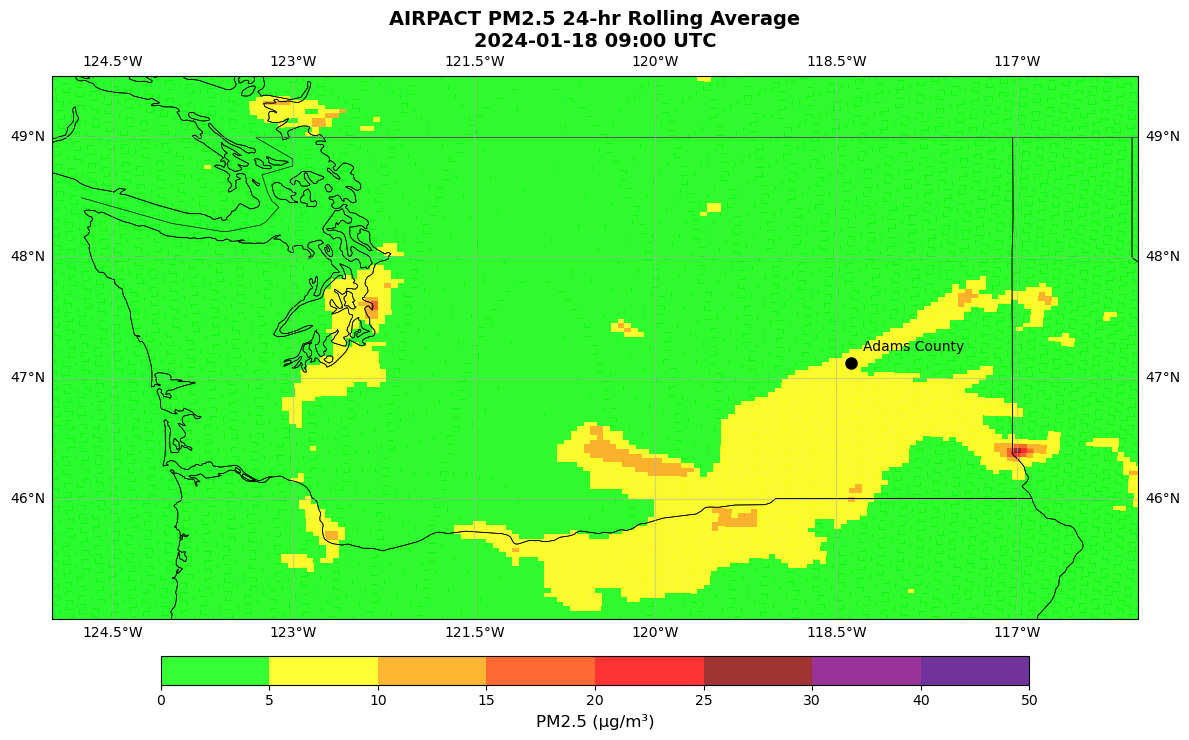

  Created 312 frames...
Processing file 14/31: PM25_L01_24hr_20240119.ncf


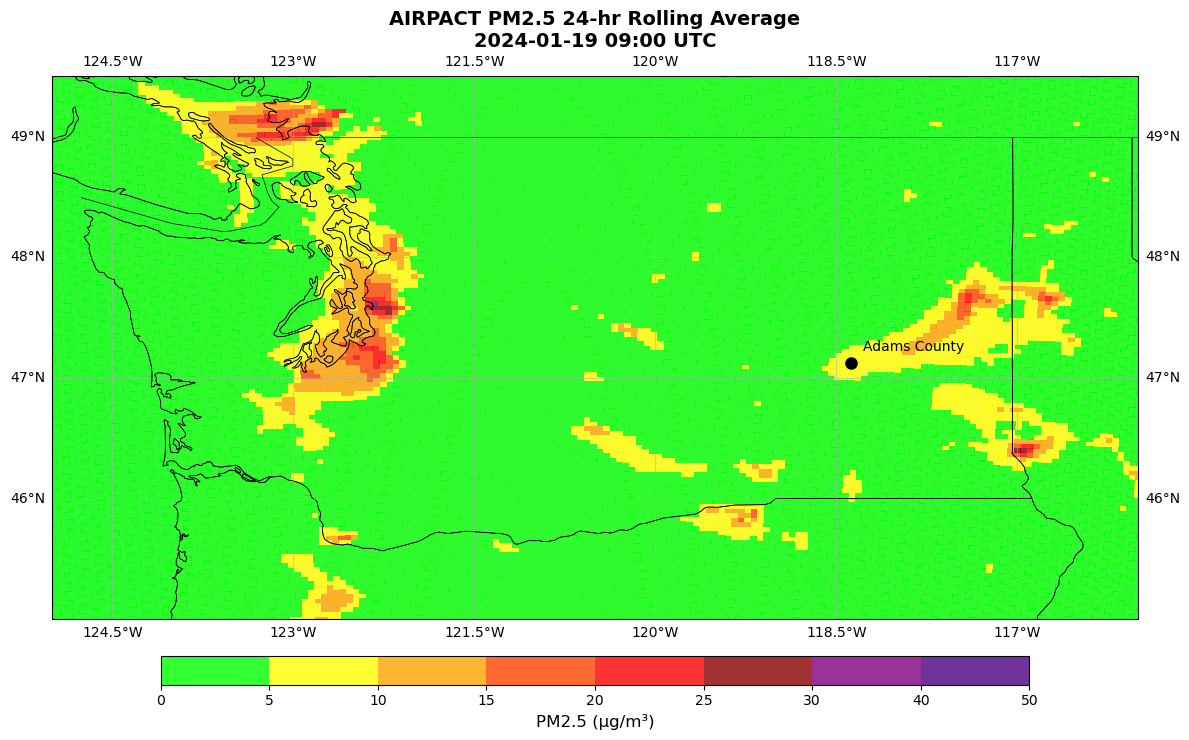

  Created 336 frames...
Processing file 15/31: PM25_L01_24hr_20240120.ncf


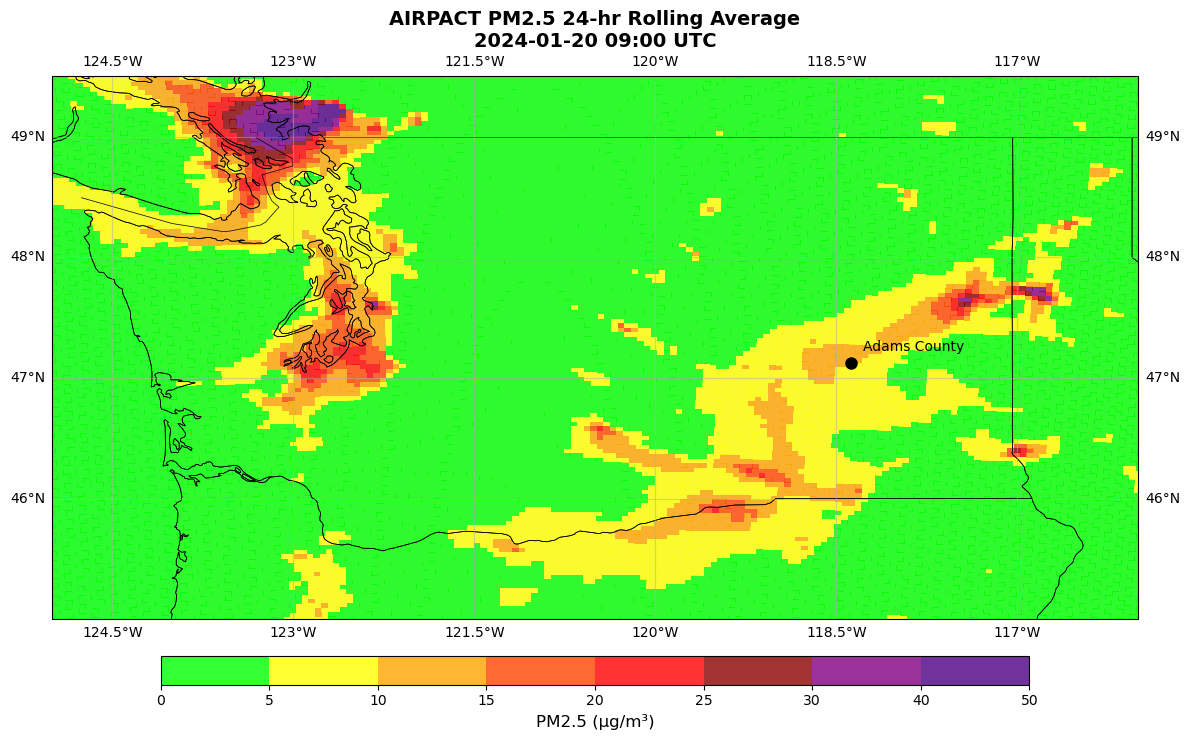

  Created 360 frames...
Processing file 16/31: PM25_L01_24hr_20240121.ncf


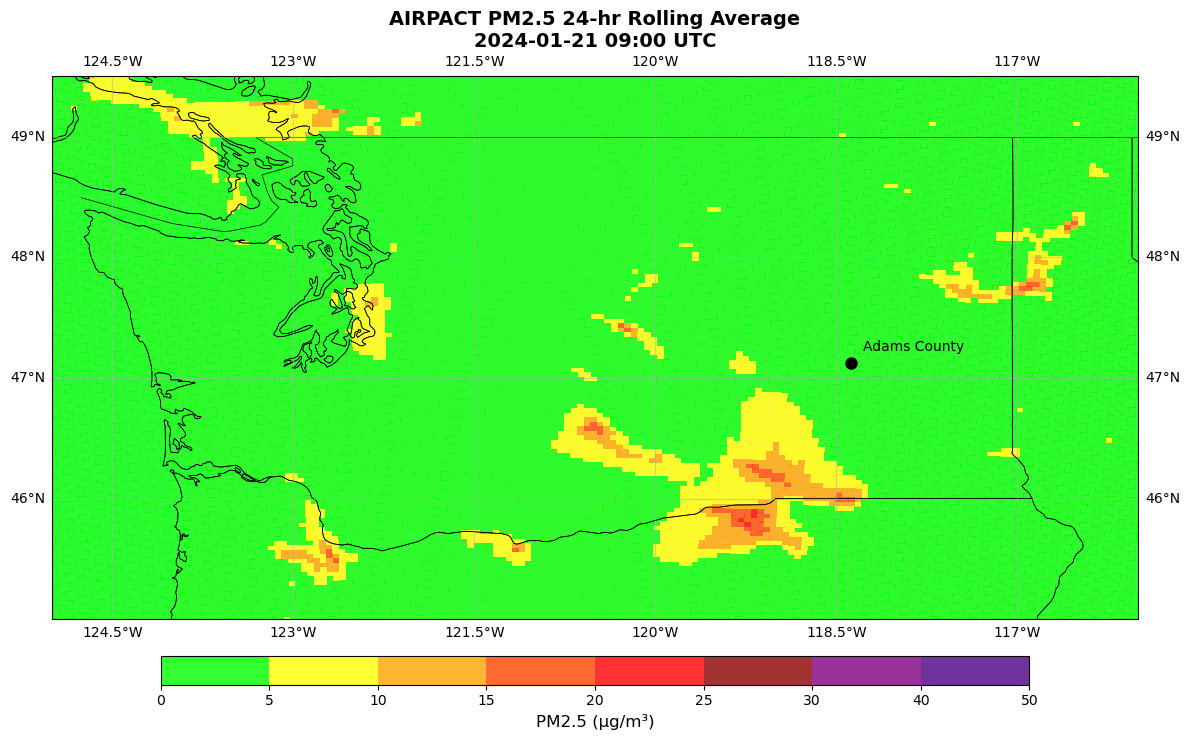

  Created 384 frames...
Processing file 17/31: PM25_L01_24hr_20240122.ncf


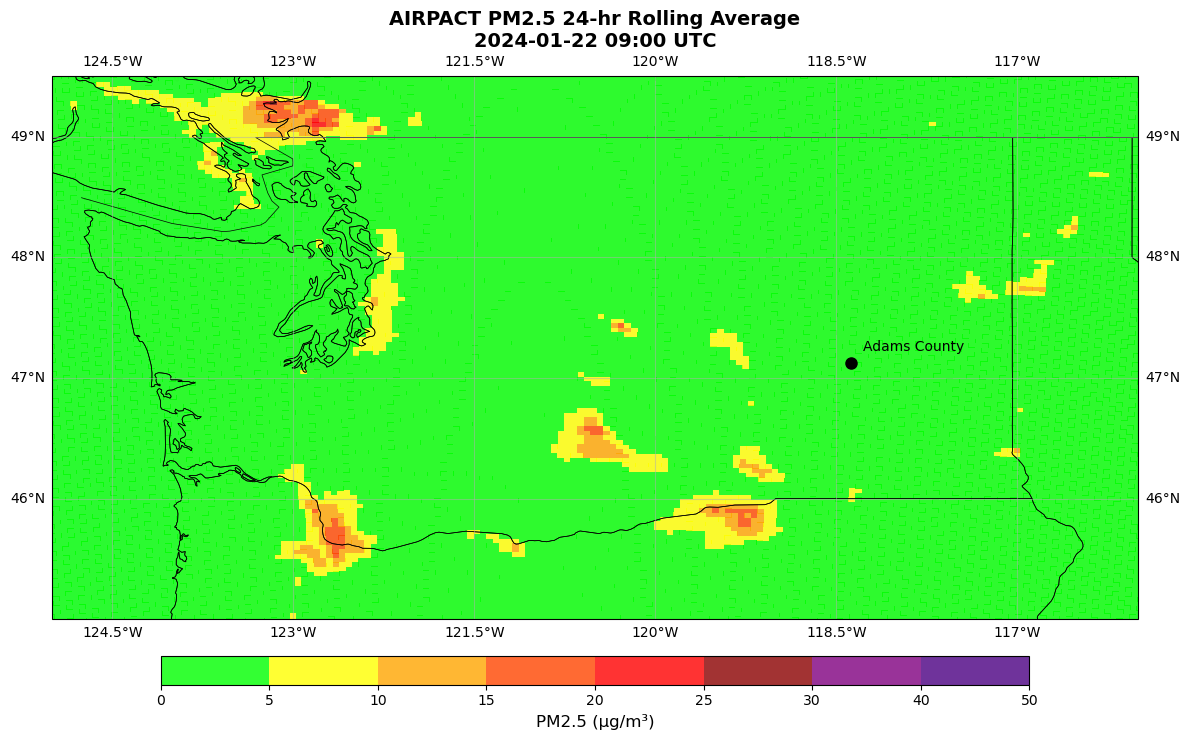

  Created 408 frames...
Processing file 18/31: PM25_L01_24hr_20240123.ncf


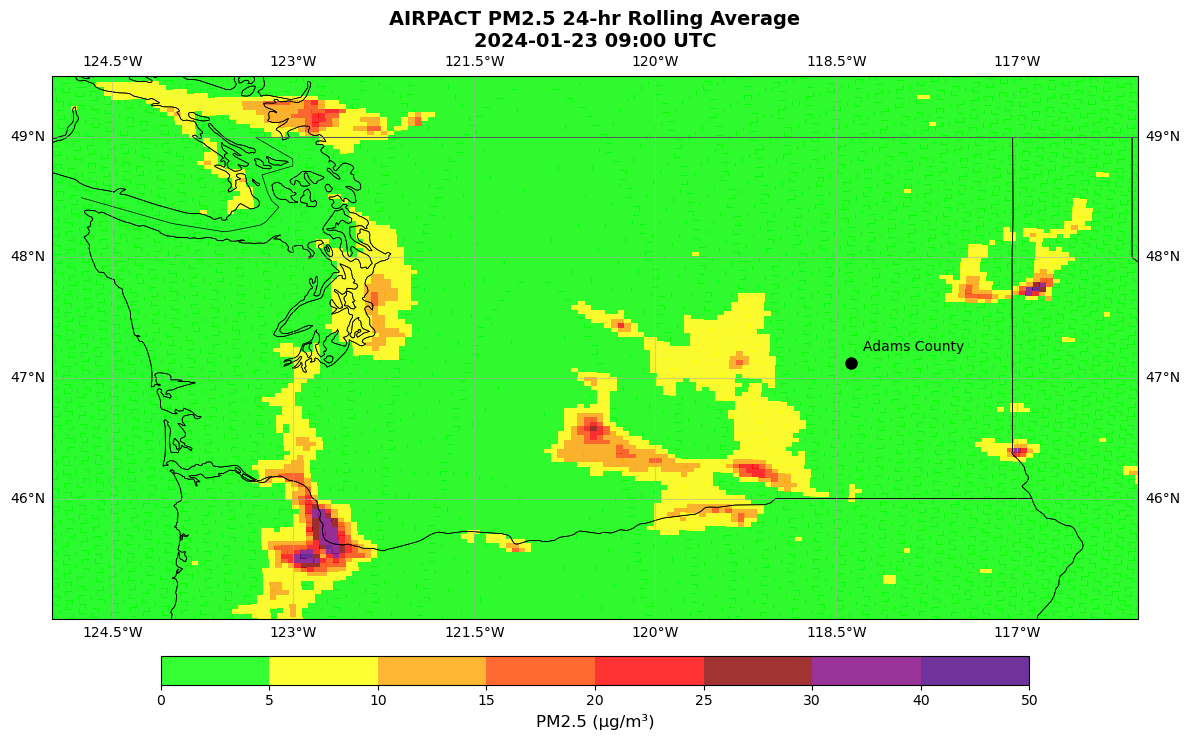

  Created 432 frames...
Processing file 19/31: PM25_L01_24hr_20240124.ncf


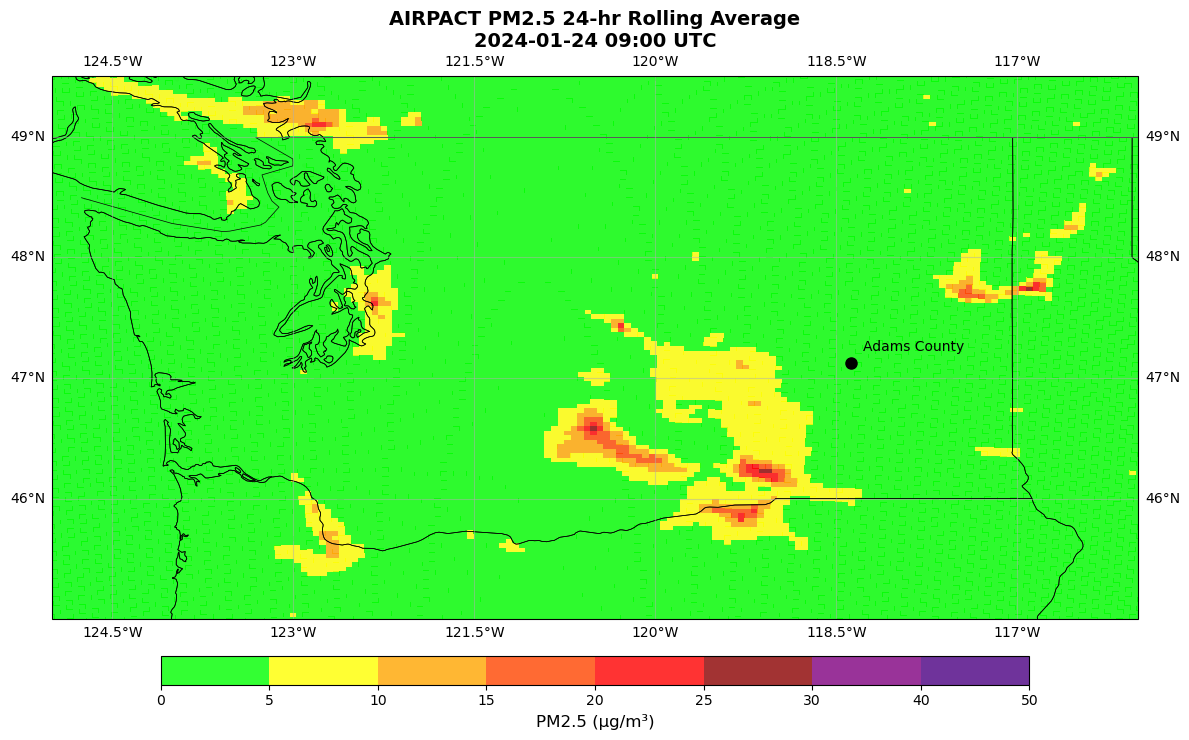

  Created 456 frames...
Processing file 20/31: PM25_L01_24hr_20240125.ncf


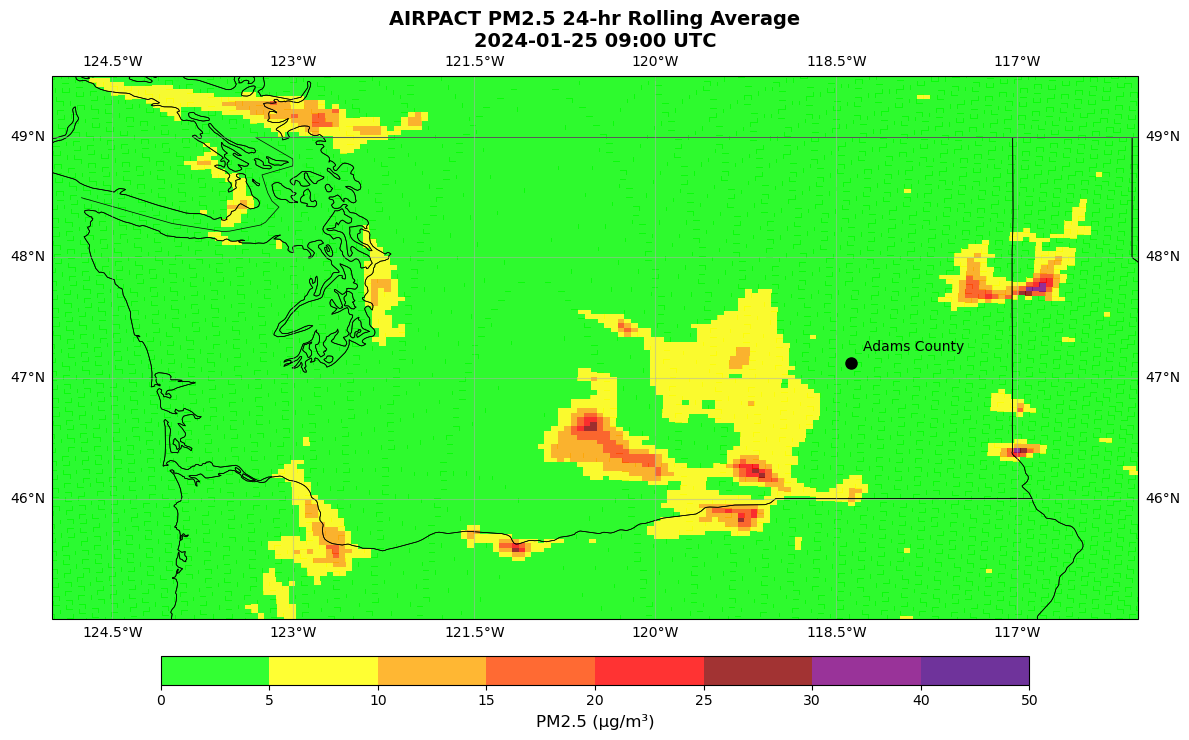

  Created 480 frames...
Processing file 21/31: PM25_L01_24hr_20240126.ncf


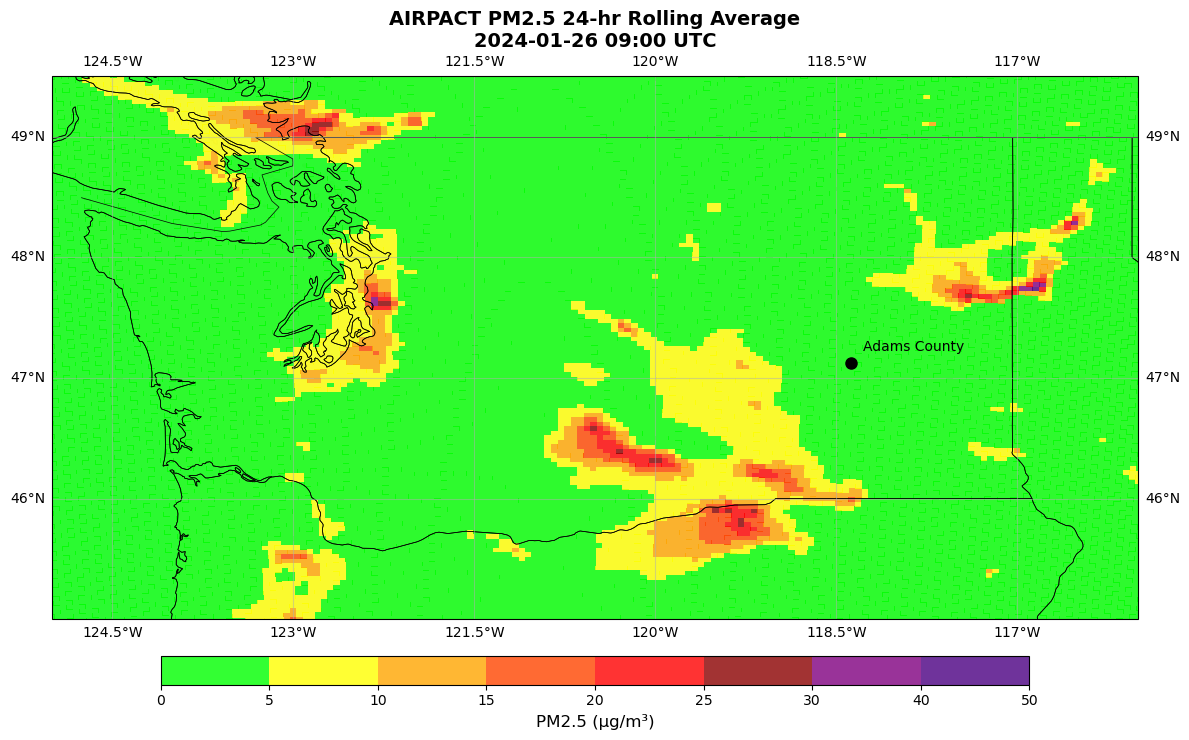

  Created 504 frames...
Processing file 22/31: PM25_L01_24hr_20240127.ncf


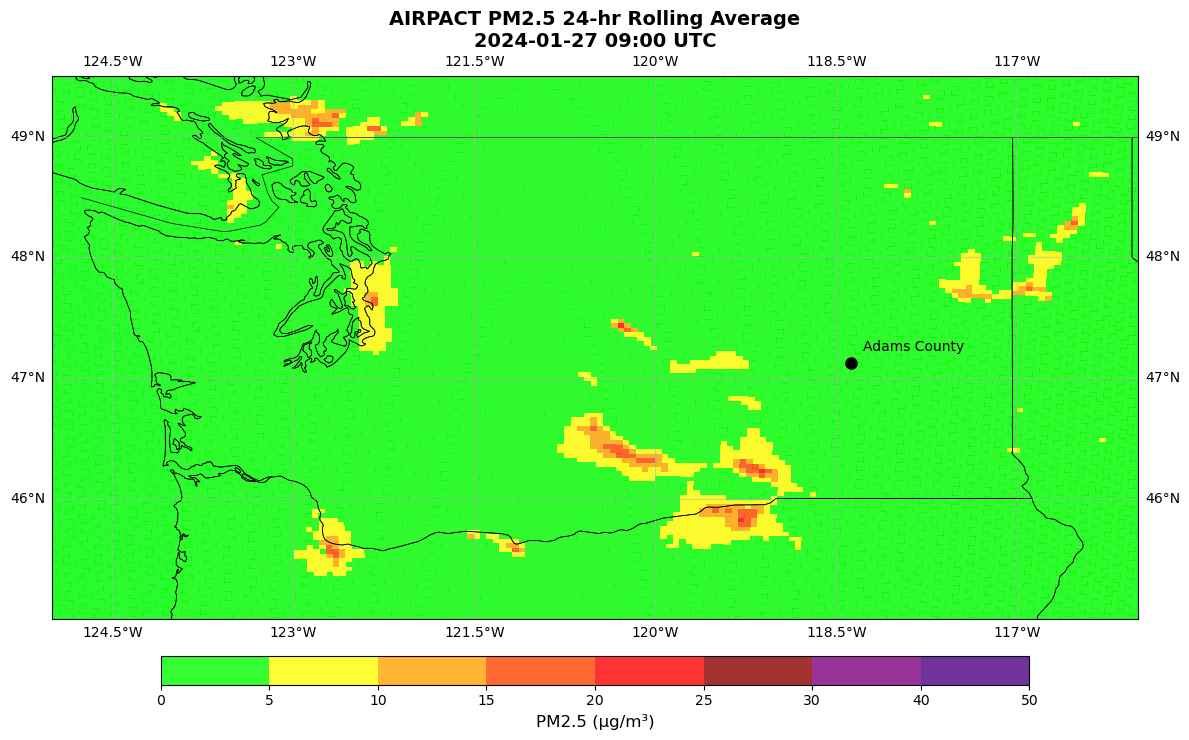

  Created 528 frames...
Processing file 23/31: PM25_L01_24hr_20240128.ncf


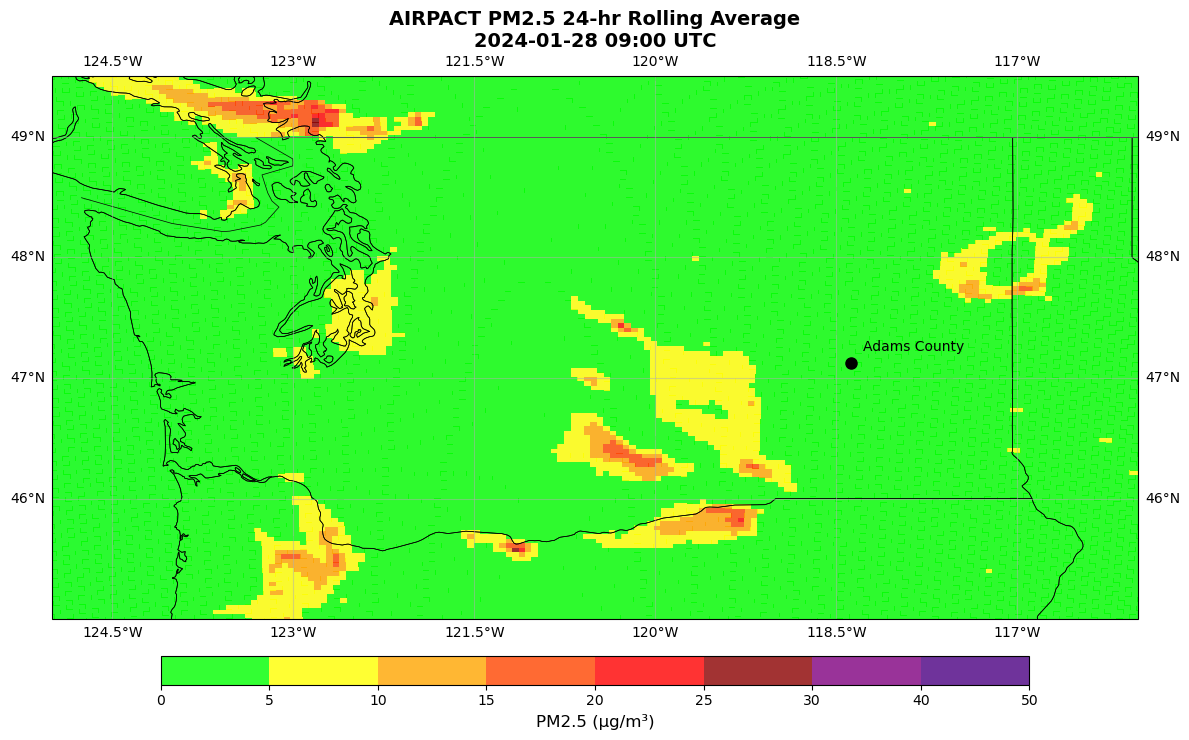

  Created 552 frames...
Processing file 24/31: PM25_L01_24hr_20240129.ncf


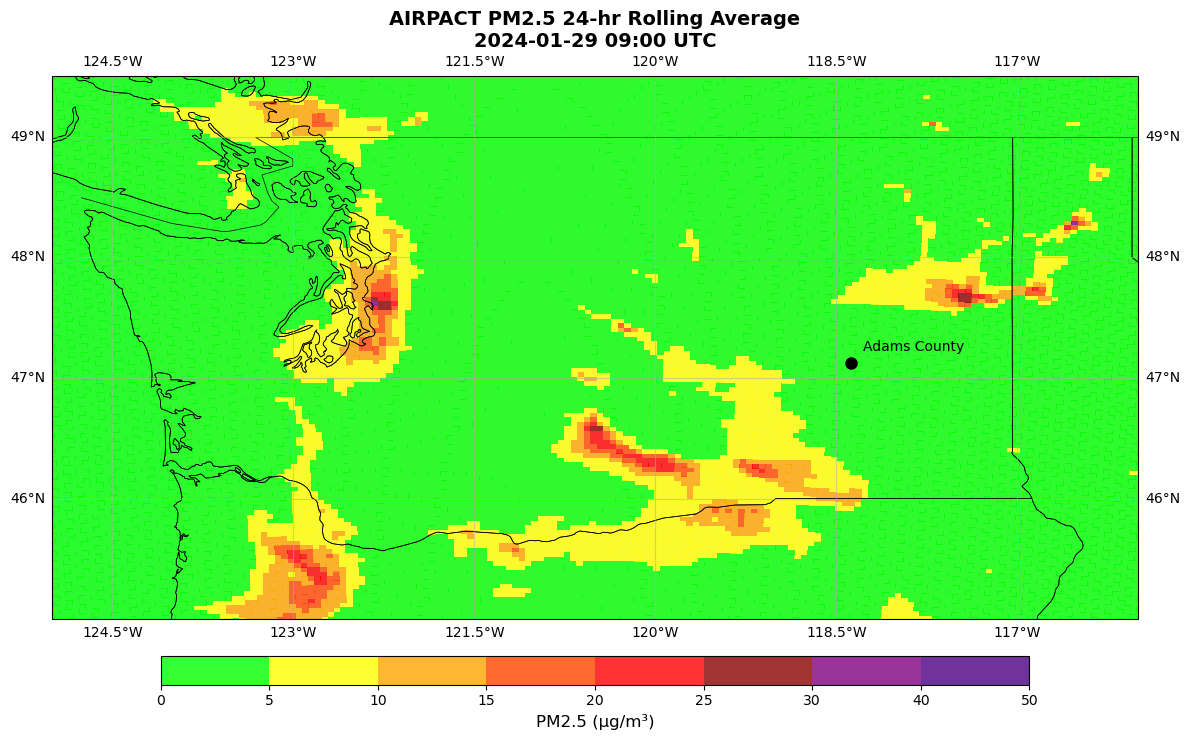

  Created 576 frames...
Processing file 25/31: PM25_L01_24hr_20240130.ncf


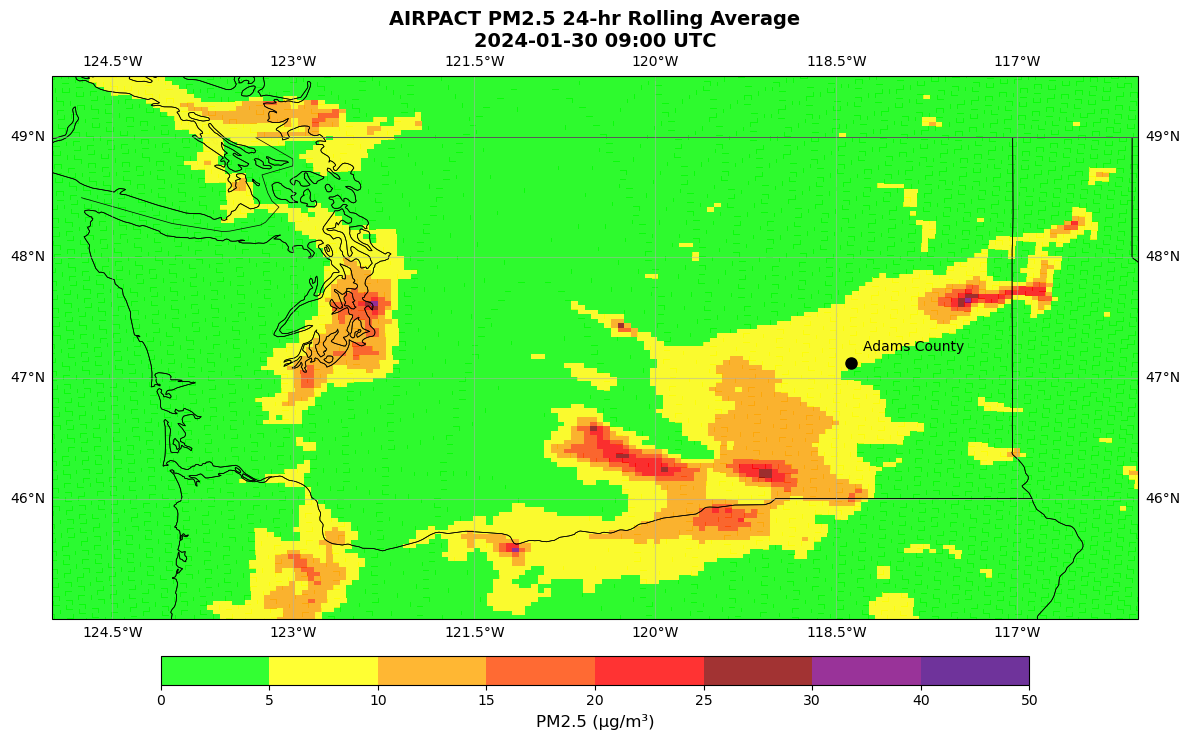

  Created 600 frames...
Processing file 26/31: PM25_L01_24hr_20240131.ncf


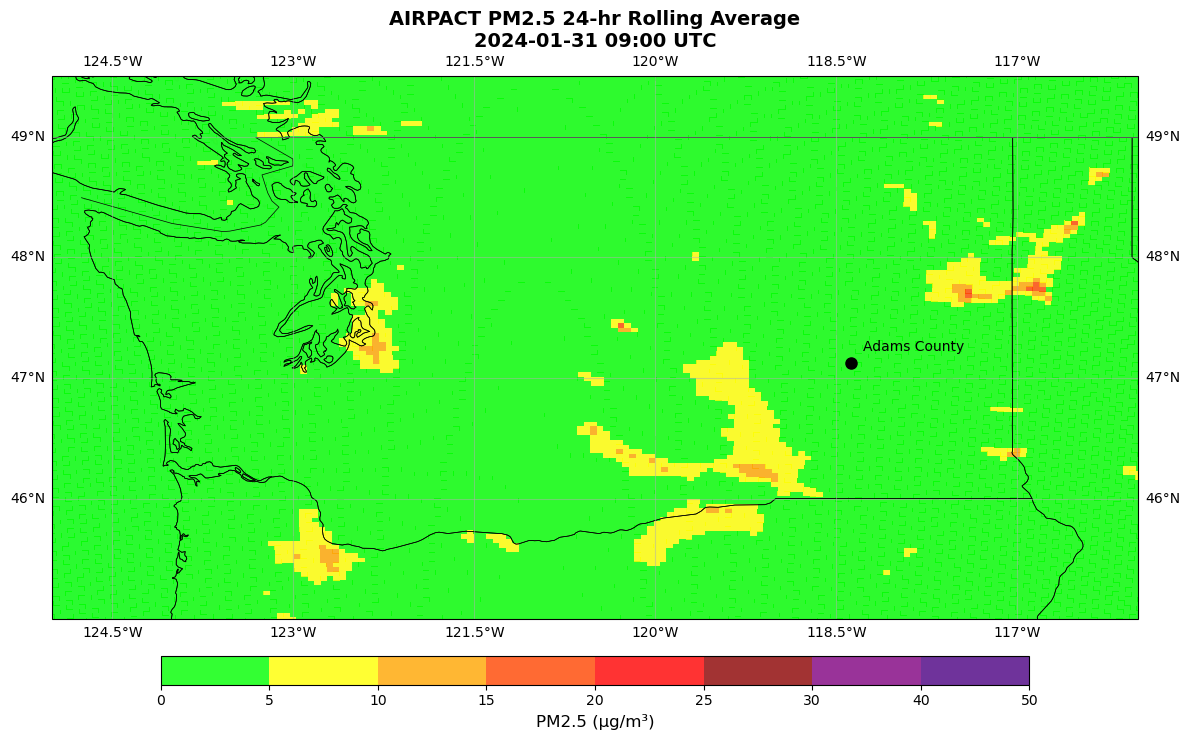

  Created 624 frames...
Processing file 27/31: PM25_L01_24hr_20240201.ncf


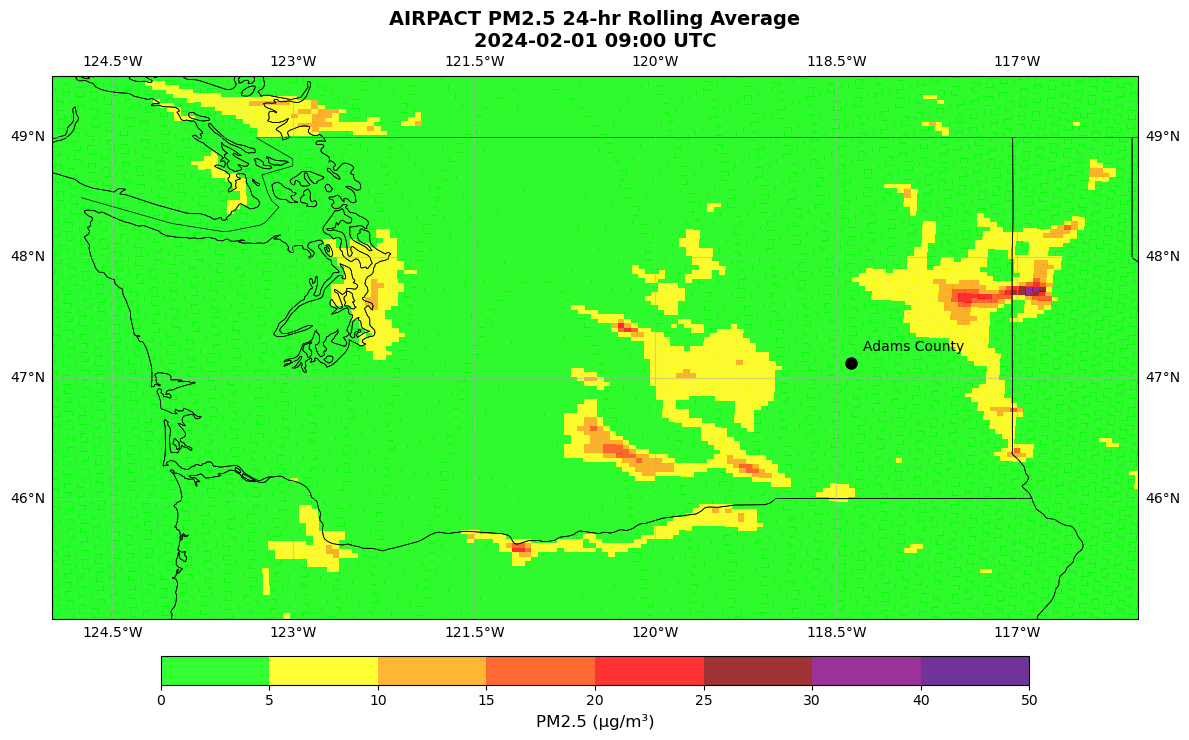

  Created 648 frames...
Processing file 28/31: PM25_L01_24hr_20240202.ncf


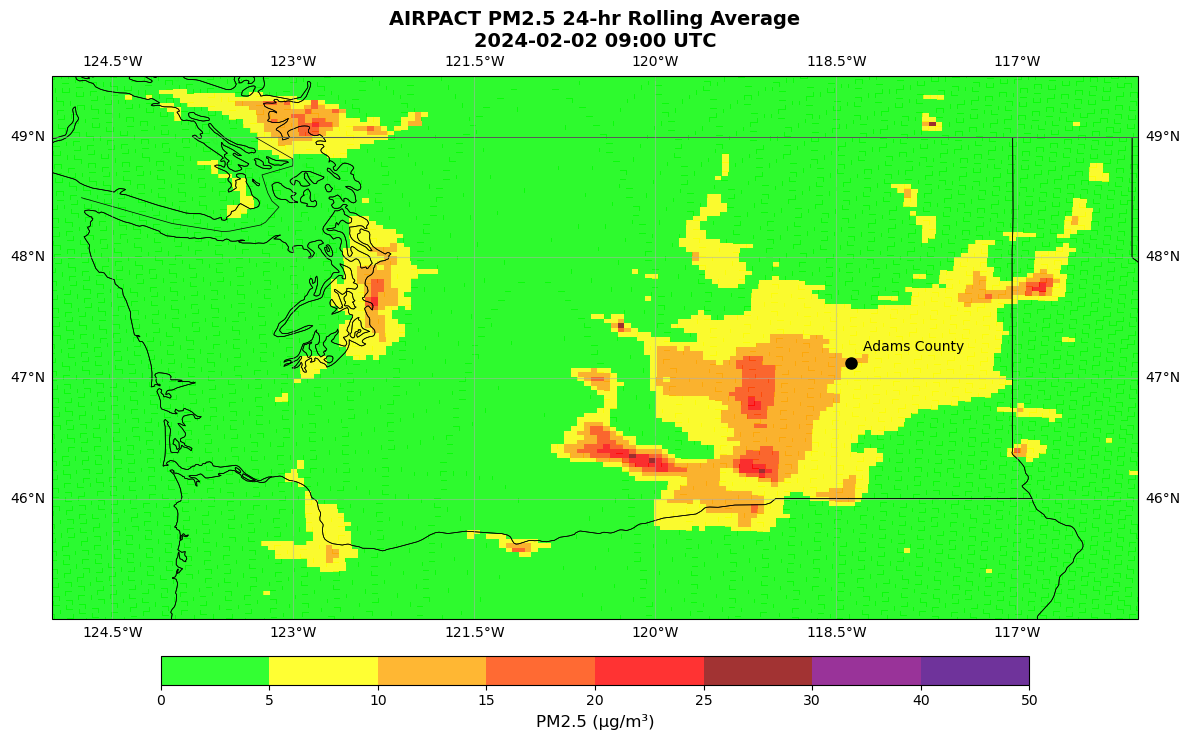

  Created 672 frames...
Processing file 29/31: PM25_L01_24hr_20240203.ncf


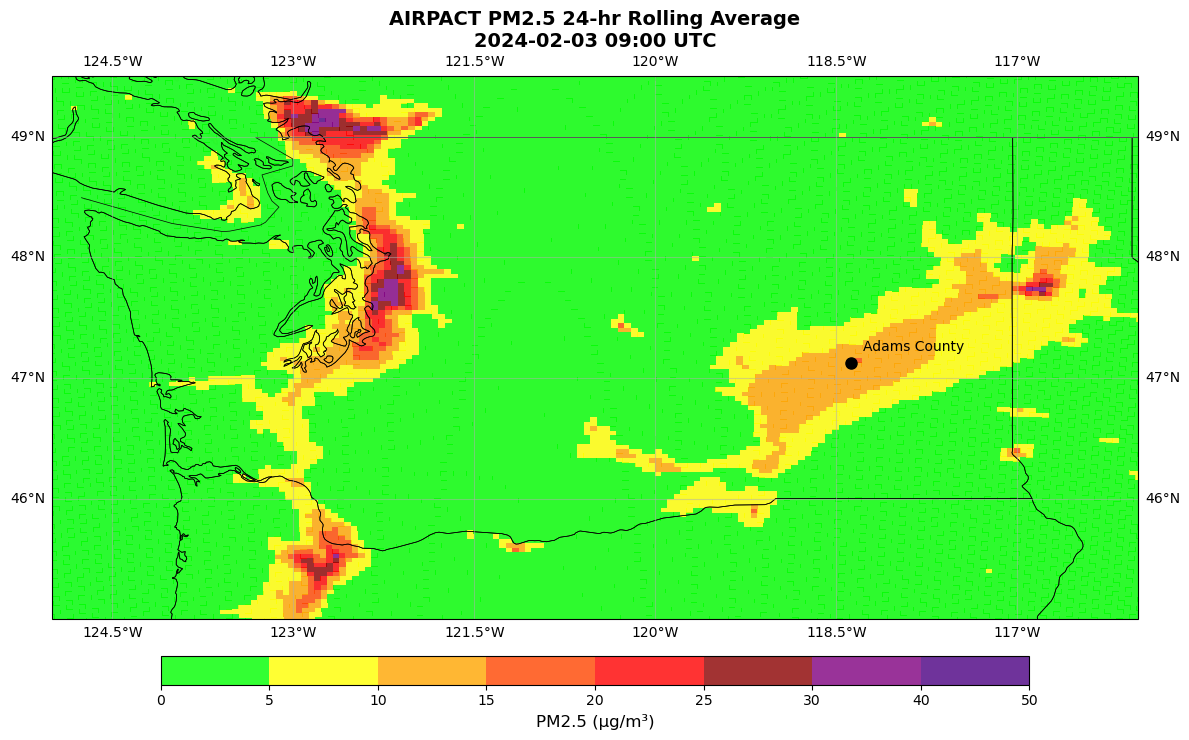

  Created 696 frames...
Processing file 30/31: PM25_L01_24hr_20240204.ncf


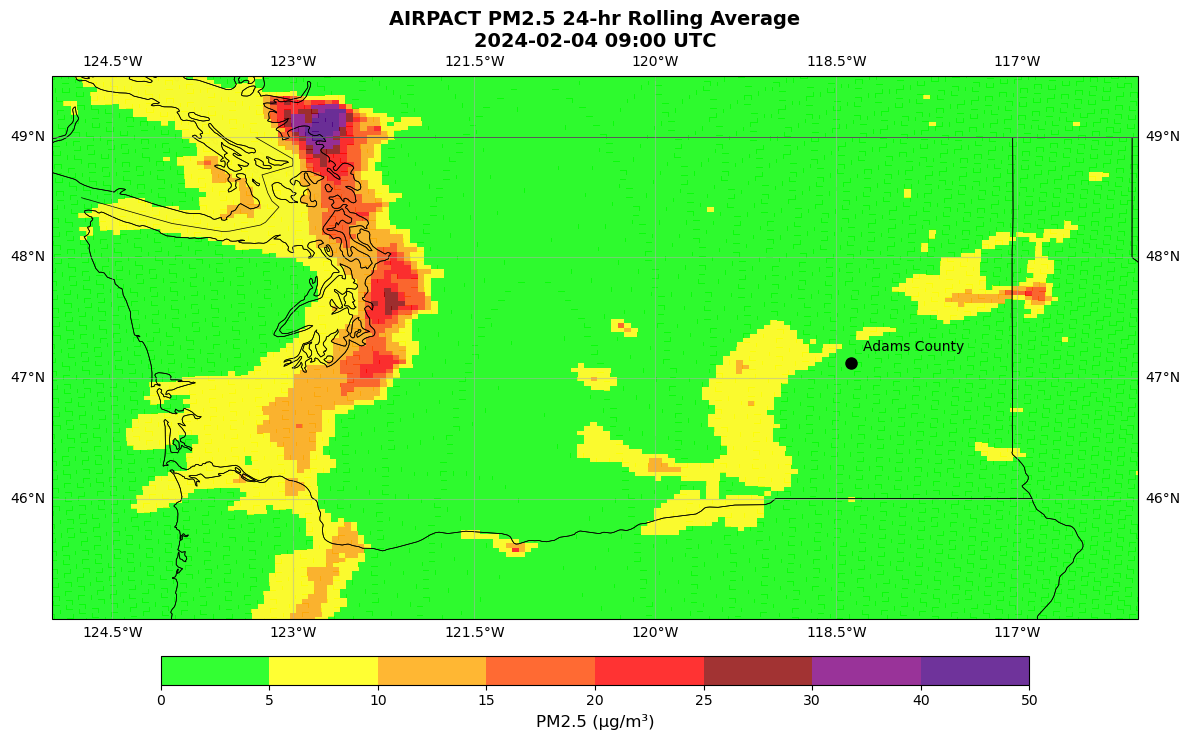

  Created 720 frames...
Processing file 31/31: PM25_L01_24hr_20240205.ncf


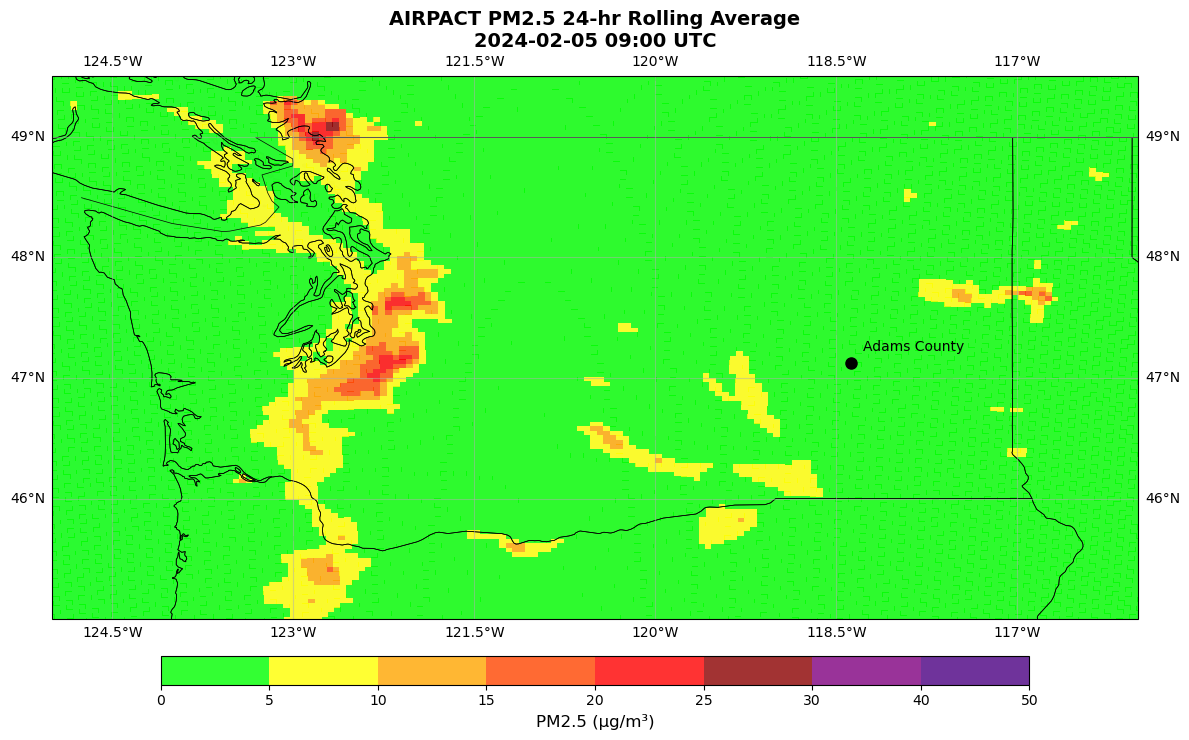

  Created 744 frames...

Created 744 total frames
Saving animation as pm25_hourly_january_2024.gif...
Animation saved: pm25_hourly_january_2024.gif
Duration: ~148.8 seconds at 5 fps

DISPLAYING: pm25_hourly_january_2024.gif
Opening with Windows default viewer...

HOURLY ANIMATION SUCCESS!
Created 744 frame animation
File: pm25_hourly_january_2024.gif
Duration: ~148.8 seconds at 5 fps
Shows every hour from Jan 1-31, 2024

What you can observe:
- Pollution episodes developing and moving
- Diurnal (daily) air quality patterns
- Regional transport of pollutants
- Weather-driven clean air events
- Rolling average smoothing effects

STEP 3: Creating daily summary...
=== CREATING DAILY SUMMARY ANIMATION ===
Processing day 1/31: PM25_L01_24hr_20240106.ncf
Processing day 2/31: PM25_L01_24hr_20240107.ncf
Processing day 3/31: PM25_L01_24hr_20240108.ncf
Processing day 4/31: PM25_L01_24hr_20240109.ncf
Processing day 5/31: PM25_L01_24hr_20240110.ncf
Processing day 6/31: PM25_L01_24hr_20240111.ncf
Pr

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import pandas as pd
import glob
import os
from PIL import Image
import io

def lcc_to_latlon(x, y, lon0=-121.0, lat0=49.0, lat1=30.0, lat2=60.0):
    """Convert Lambert Conformal Conic to lat/lon"""
    lon0_r = np.radians(lon0)
    lat0_r = np.radians(lat0)
    lat1_r = np.radians(lat1)
    lat2_r = np.radians(lat2)
    
    R = 6371000.0
    n = np.log(np.cos(lat1_r) / np.cos(lat2_r)) / np.log(np.tan(np.pi/4 + lat2_r/2) / np.tan(np.pi/4 + lat1_r/2))
    F = np.cos(lat1_r) * (np.tan(np.pi/4 + lat1_r/2)**n) / n
    rho0 = R * F / (np.tan(np.pi/4 + lat0_r/2)**n)
    
    rho = np.sqrt(x**2 + (rho0 - y)**2)
    theta = np.arctan2(x, rho0 - y)
    
    lat = 2 * np.arctan((R * F / rho)**(1/n)) - np.pi/2
    lon = lon0_r + theta / n
    
    return np.degrees(lon), np.degrees(lat)

def display_gif(filename):
    """Display the created GIF using various methods"""
    import webbrowser
    import subprocess
    import platform
    
    print(f"\n" + "="*50)
    print(f"DISPLAYING: {filename}")
    print("="*50)
    
    try:
        # Method 1: Try to open with default system viewer
        if platform.system() == "Windows":
            os.startfile(filename)
            print("Opening with Windows default viewer...")
            
        elif platform.system() == "Darwin":  # macOS
            subprocess.run(["open", filename])
            print("Opening with macOS default viewer...")
            
        elif platform.system() == "Linux":
            subprocess.run(["xdg-open", filename])
            print("Opening with Linux default viewer...")
            
        else:
            # Method 2: Try web browser
            webbrowser.open(f"file://{os.path.abspath(filename)}")
            print("Opening in web browser...")
            
    except Exception as e:
        print(f"Could not auto-open GIF: {e}")
        print(f"Manual: Navigate to {os.path.abspath(filename)}")
        
        # Method 3: Try to display using PIL
        try:
            gif = Image.open(filename)
            print(f"\nGIF Information:")
            print(f"   Size: {gif.size}")
            print(f"   Frames: {gif.n_frames}")
            print(f"   Mode: {gif.mode}")
            
            # Show first frame
            first_frame = gif.copy()
            first_frame.show()
            print("Displaying first frame...")
            
        except Exception as e2:
            print(f"Could not display with PIL: {e2}")
            print(f"Try opening manually: {filename}")

def preview_single_frame(data_dir, file_index=15, timestep=12):
    """Create and display a single frame as preview"""
    
    print(f"\n" + "="*50)
    print("CREATING PREVIEW FRAME")
    print("="*50)
    
    ncf_files = sorted(glob.glob(os.path.join(data_dir, "*.ncf")))
    
    if file_index >= len(ncf_files):
        print(f"File index {file_index} too high. Max: {len(ncf_files)-1}")
        return
        
    preview_file = ncf_files[file_index]
    print(f"Preview file: {os.path.basename(preview_file)}")
    
    try:
        # Load file and grid info
        ds = xr.open_dataset(preview_file)
        
        xorig = ds.attrs['XORIG']
        yorig = ds.attrs['YORIG'] 
        xcell = ds.attrs['XCELL']
        ycell = ds.attrs['YCELL']
        nrows = ds.attrs['NROWS']
        ncols = ds.attrs['NCOLS']
        
        x_proj = np.arange(ncols) * xcell + xorig + xcell/2
        y_proj = np.arange(nrows) * ycell + yorig + ycell/2
        X_proj, Y_proj = np.meshgrid(x_proj, y_proj)
        grid_lons, grid_lats = lcc_to_latlon(X_proj, Y_proj)
        
        # Get data for specified timestep
        timestep = min(timestep, ds.dims['TSTEP']-1)
        pm25_data = ds['RollingA24_PM25'].isel(TSTEP=timestep, LAY=0).values
        
        # Get timestamp
        tflag = ds['TFLAG'].isel(TSTEP=timestep, VAR=0).values
        date_val = int(tflag[0])
        time_val = int(tflag[1])
        
        year = date_val // 1000
        day_of_year = date_val % 1000
        base_date = pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1)
        
        time_str = f"{time_val:06d}"
        hour = int(time_str[:2])
        minute = int(time_str[2:4])
        timestamp = base_date + timedelta(hours=hour, minutes=minute)
        
        # Create plot
        fig = plt.figure(figsize=(14, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-125, -116, 45, 49.5], crs=ccrs.PlateCarree())
        
        # Map features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax.add_feature(cfeature.STATES, linewidth=0.8)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
        
        # Color scale
        levels = [0, 5, 10, 15, 20, 25, 30, 40, 50]
        colors = ['#00ff00', '#ffff00', '#ffa500', '#ff4500', '#ff0000', '#8b0000', '#800080', '#4b0082']
        cmap = plt.matplotlib.colors.ListedColormap(colors)
        norm = BoundaryNorm(levels, cmap.N)
        
        # Plot data
        mesh = ax.pcolormesh(grid_lons, grid_lats, pm25_data, 
                           transform=ccrs.PlateCarree(),
                           cmap=cmap, norm=norm, alpha=0.8)
        
        # Colorbar
        cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', 
                          pad=0.05, shrink=0.8, aspect=30)
        cbar.set_label('PM2.5 24-hr Rolling Average (μg/m³)', fontsize=14)
        
        # Title
        plt.title(f'AIRPACT PM2.5 Preview\n{timestamp.strftime("%Y-%m-%d %H:%M")} UTC',
                 fontsize=16, fontweight='bold')
        
        # Adams County
        adams_lat, adams_lon = 47.120, -118.382
        ax.plot(adams_lon, adams_lat, 'ko', markersize=12, 
               transform=ccrs.PlateCarree())
        ax.text(adams_lon+0.1, adams_lat+0.1, 'Adams County', 
               transform=ccrs.PlateCarree(), fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax.gridlines(draw_labels=True, alpha=0.5)
        plt.tight_layout()
        
        # Display
        plt.show()
        
        # Stats
        valid_data = pm25_data[~np.isnan(pm25_data)]
        print(f"\nPreview Statistics:")
        print(f"   Timestamp: {timestamp}")
        print(f"   PM2.5 Range: {valid_data.min():.1f} - {valid_data.max():.1f} μg/m³")
        print(f"   Mean: {valid_data.mean():.1f} μg/m³")
        
        ds.close()
        
    except Exception as e:
        print(f"Error creating preview: {e}")
        return None

def create_pm25_animation(data_dir, output_filename="pm25_january_2024.gif", 
                         show_frames=False, show_every_n=24, show_final_gif=True):
    """Create animated GIF of PM2.5 data for January 2024"""
    
    print("=== CREATING PM2.5 ANIMATION ===")
    
    # Find all NetCDF files
    ncf_files = sorted(glob.glob(os.path.join(data_dir, "*.ncf")))
    
    # Take January files (first 31 files)
    january_files = ncf_files[:31]
    print(f"Found {len(january_files)} January files")
    
    # Load first file to get grid information
    ds_first = xr.open_dataset(january_files[0])
    
    # Get grid parameters
    xorig = ds_first.attrs['XORIG']
    yorig = ds_first.attrs['YORIG'] 
    xcell = ds_first.attrs['XCELL']
    ycell = ds_first.attrs['YCELL']
    nrows = ds_first.attrs['NROWS']
    ncols = ds_first.attrs['NCOLS']
    
    print(f"Grid: {nrows} x {ncols}, Cell size: {xcell/1000:.1f} km")
    
    # Create coordinate arrays
    x_proj = np.arange(ncols) * xcell + xorig + xcell/2
    y_proj = np.arange(nrows) * ycell + yorig + ycell/2
    X_proj, Y_proj = np.meshgrid(x_proj, y_proj)
    
    # Convert to lat/lon
    grid_lons, grid_lats = lcc_to_latlon(X_proj, Y_proj)
    
    # Find data range for consistent color scale
    print("Determining data range...")
    all_data = []
    for i, file_path in enumerate(january_files[:5]):  # Sample first 5 files
        ds = xr.open_dataset(file_path)
        data = ds['RollingA24_PM25'].isel(LAY=0).values
        all_data.extend(data.flatten())
        ds.close()
    
    # Set color scale
    vmin = 0
    vmax = np.percentile([x for x in all_data if not np.isnan(x)], 95)  # 95th percentile
    print(f"Color scale: {vmin} to {vmax:.1f} μg/m³")
    
    # Define PM2.5 color levels and colormap
    levels = [0, 5, 10, 15, 20, 25, 30, 40, 50]
    colors = ['#00ff00', '#ffff00', '#ffa500', '#ff4500', '#ff0000', '#8b0000', '#800080', '#4b0082']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N)
    
    # Create frames for animation
    frames = []
    frame_count = 0
    
    print("\nCreating animation frames...")
    
    for file_idx, file_path in enumerate(january_files):
        print(f"Processing file {file_idx+1}/{len(january_files)}: {os.path.basename(file_path)}")
        
        try:
            ds = xr.open_dataset(file_path)
            
            # Process each timestep in the file
            for t in range(ds.dims['TSTEP']):
                # Get timestamp
                tflag = ds['TFLAG'].isel(TSTEP=t, VAR=0).values
                date_val = int(tflag[0])
                time_val = int(tflag[1])
                
                # Convert to datetime
                year = date_val // 1000
                day_of_year = date_val % 1000
                base_date = pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1)
                
                time_str = f"{time_val:06d}"
                hour = int(time_str[:2])
                minute = int(time_str[2:4])
                
                timestamp = base_date + timedelta(hours=hour, minutes=minute)
                
                # Get PM2.5 data for this timestep
                pm25_data = ds['RollingA24_PM25'].isel(TSTEP=t, LAY=0).values
                
                # Create plot
                fig = plt.figure(figsize=(12, 8))
                ax = plt.axes(projection=ccrs.PlateCarree())
                
                # Set map extent (Washington state area)
                ax.set_extent([-125, -116, 45, 49.5], crs=ccrs.PlateCarree())
                
                # Add map features
                ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                ax.add_feature(cfeature.BORDERS, linewidth=0.5)
                ax.add_feature(cfeature.STATES, linewidth=0.5)
                ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
                ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
                
                # Plot PM2.5 data
                mesh = ax.pcolormesh(grid_lons, grid_lats, pm25_data, 
                                   transform=ccrs.PlateCarree(),
                                   cmap=cmap, norm=norm, alpha=0.8)
                
                # Add colorbar
                cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', 
                                  pad=0.05, shrink=0.8, aspect=30)
                cbar.set_label('PM2.5 (μg/m³)', fontsize=12)
                
                # Add title with timestamp
                plt.title(f'AIRPACT PM2.5 24-hr Rolling Average\n{timestamp.strftime("%Y-%m-%d %H:%M")} UTC',
                         fontsize=14, fontweight='bold')
                
                # Add Adams County marker
                adams_lat, adams_lon = 47.120, -118.382
                ax.plot(adams_lon, adams_lat, 'ko', markersize=8, 
                       transform=ccrs.PlateCarree(), label='Adams County')
                ax.text(adams_lon+0.1, adams_lat+0.1, 'Adams County', 
                       transform=ccrs.PlateCarree(), fontsize=10)
                
                # Add grid lines
                ax.gridlines(draw_labels=True, alpha=0.5)
                
                plt.tight_layout()
                
                # Optional: Display frame
                if show_frames and (frame_count % show_every_n == 0):
                    plt.show(block=False)
                    plt.pause(0.5)  # Brief pause to see the frame
                
                # Save frame to memory
                buf = io.BytesIO()
                plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
                buf.seek(0)
                img = Image.open(buf)
                frames.append(img.copy())
                buf.close()
                plt.close()
                
                frame_count += 1
                
                # Progress update
                if frame_count % 24 == 0:
                    print(f"  Created {frame_count} frames...")
            
            ds.close()
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    print(f"\nCreated {len(frames)} total frames")
    
    # Save as GIF
    print(f"Saving animation as {output_filename}...")
    if frames:
        frames[0].save(
            output_filename,
            save_all=True,
            append_images=frames[1:],
            duration=200,  # 200ms per frame (5 fps)
            loop=0
        )
        print(f"Animation saved: {output_filename}")
        print(f"Duration: ~{len(frames)*0.2:.1f} seconds at 5 fps")
        
        # Optional: Display final GIF
        if show_final_gif:
            display_gif(output_filename)
            
    else:
        print("No frames created!")
    
    return len(frames)

def create_daily_summary_gif(data_dir, output_filename="pm25_daily_january_2024.gif",
                           show_frames=False, show_final_gif=True):
    """Create a simpler daily summary animation (one frame per day)"""
    
    print("=== CREATING DAILY SUMMARY ANIMATION ===")
    
    ncf_files = sorted(glob.glob(os.path.join(data_dir, "*.ncf")))
    january_files = ncf_files[:31]
    
    # Load first file for grid
    ds_first = xr.open_dataset(january_files[0])
    xorig = ds_first.attrs['XORIG']
    yorig = ds_first.attrs['YORIG'] 
    xcell = ds_first.attrs['XCELL']
    ycell = ds_first.attrs['YCELL']
    nrows = ds_first.attrs['NROWS']
    ncols = ds_first.attrs['NCOLS']
    
    x_proj = np.arange(ncols) * xcell + xorig + xcell/2
    y_proj = np.arange(nrows) * ycell + yorig + ycell/2
    X_proj, Y_proj = np.meshgrid(x_proj, y_proj)
    grid_lons, grid_lats = lcc_to_latlon(X_proj, Y_proj)
    ds_first.close()
    
    frames = []
    
    # Color scale
    levels = [0, 5, 10, 15, 20, 25, 30, 40, 50]
    colors = ['#00ff00', '#ffff00', '#ffa500', '#ff4500', '#ff0000', '#8b0000', '#800080', '#4b0082']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N)
    
    for file_idx, file_path in enumerate(january_files):
        print(f"Processing day {file_idx+1}/{len(january_files)}: {os.path.basename(file_path)}")
        
        try:
            ds = xr.open_dataset(file_path)
            
            # Use noon data (timestep ~12) for daily representation
            noon_idx = min(12, ds.dims['TSTEP']-1)
            pm25_data = ds['RollingA24_PM25'].isel(TSTEP=noon_idx, LAY=0).values
            
            # Get date for title
            tflag = ds['TFLAG'].isel(TSTEP=noon_idx, VAR=0).values
            date_val = int(tflag[0])
            year = date_val // 1000
            day_of_year = date_val % 1000
            date = pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1)
            
            # Create plot
            fig = plt.figure(figsize=(12, 8))
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.set_extent([-125, -116, 45, 49.5], crs=ccrs.PlateCarree())
            
            # Add features
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.add_feature(cfeature.STATES, linewidth=0.5)
            ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
            ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
            
            # Plot data
            mesh = ax.pcolormesh(grid_lons, grid_lats, pm25_data, 
                               transform=ccrs.PlateCarree(),
                               cmap=cmap, norm=norm, alpha=0.8)
            
            # Colorbar
            cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', 
                              pad=0.05, shrink=0.8, aspect=30)
            cbar.set_label('PM2.5 24-hr Rolling Average (μg/m³)', fontsize=12)
            
            # Title
            plt.title(f'AIRPACT PM2.5 - {date.strftime("%B %d, %Y")}',
                     fontsize=16, fontweight='bold')
            
            # Adams County marker
            adams_lat, adams_lon = 47.120, -118.382
            ax.plot(adams_lon, adams_lat, 'ko', markersize=10, 
                   transform=ccrs.PlateCarree())
            ax.text(adams_lon+0.1, adams_lat+0.1, 'Adams County', 
                   transform=ccrs.PlateCarree(), fontsize=12, fontweight='bold')
            
            ax.gridlines(draw_labels=True, alpha=0.5)
            plt.tight_layout()
            
            # Optional: Display frame
            if show_frames:
                plt.show(block=False)
                plt.pause(1.0)  # Pause to see each daily frame
            
            # Save frame
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
            buf.seek(0)
            img = Image.open(buf)
            frames.append(img.copy())
            buf.close()
            plt.close()
            
            ds.close()
            
        except Exception as e:
            print(f"Error: {e}")
            continue
    
    # Save GIF
    if frames:
        frames[0].save(
            output_filename,
            save_all=True,
            append_images=frames[1:],
            duration=500,  # 500ms per frame (2 fps)
            loop=0
        )
        print(f"Daily animation saved: {output_filename}")
        
        # Optional: Display final GIF
        if show_final_gif:
            display_gif(output_filename)
    
    return len(frames)

# USAGE - HOURLY ANIMATION WITH DISPLAY
if __name__ == "__main__":
    data_directory = r"C:\Users\priom\Downloads\test_pm25\pm25_data\2024"
    
    print("="*60)
    print("PM2.5 ANIMATION CREATOR WITH DISPLAY")
    print("="*60)
    
    # Step 1: Create preview frame to test
    print("STEP 1: Creating preview frame...")
    preview_single_frame(data_directory, file_index=15, timestep=12)
    
    input("\nPress Enter to continue with full animation creation...")
    
    print("\n" + "="*60)
    print("STEP 2: CREATING HOURLY PM2.5 ANIMATION")
    print("="*60)
    print("Settings:")
    print("- ~744 frames (every hour of January)")
    print("- Display every 24th frame during creation")
    print("- Auto-display final GIF when complete")
    print("- Expected file size: 50-150 MB")
    print("- Processing time: 10-30 minutes")
    print("="*60)
    
    # Create hourly animation with display options
    frame_count = create_pm25_animation(
        data_dir=data_directory, 
        output_filename="pm25_hourly_january_2024.gif",
        show_frames=True,        # Show frames during creation
        show_every_n=24,         # Show every 24th frame (daily)
        show_final_gif=True      # Display final GIF
    )
    
    if frame_count > 0:
        print(f"\n" + "="*50)
        print("HOURLY ANIMATION SUCCESS!")
        print("="*50)
        print(f"Created {frame_count} frame animation")
        print(f"File: pm25_hourly_january_2024.gif")
        print(f"Duration: ~{frame_count*0.2:.1f} seconds at 5 fps")
        print(f"Shows every hour from Jan 1-31, 2024")
        
        print(f"\nWhat you can observe:")
        print(f"- Pollution episodes developing and moving")
        print(f"- Diurnal (daily) air quality patterns") 
        print(f"- Regional transport of pollutants")
        print(f"- Weather-driven clean air events")
        print(f"- Rolling average smoothing effects")
        
    else:
        print("ERROR: No frames created!")
        print("Check your data directory and file permissions")
    
    # Step 3: Also create daily summary for comparison
    print(f"\n" + "="*50)
    print("STEP 3: Creating daily summary...")
    daily_frames = create_daily_summary_gif(
        data_dir=data_directory, 
        output_filename="pm25_daily_january_2024.gif",
        show_frames=False,       # Don't show daily frames (too slow)
        show_final_gif=True      # Display final daily GIF
    )
    
    if daily_frames > 0:
        print(f"\n" + "="*50)
        print("BOTH ANIMATIONS COMPLETE!")
        print("="*50)
        print(f"Hourly: pm25_hourly_january_2024.gif ({frame_count} frames)")
        print(f"Daily: pm25_daily_january_2024.gif ({daily_frames} frames)")
        print(f"\nFiles saved in: {data_directory}")
        
        print(f"\nRecommendations:")
        print(f"- View daily version first (smaller, faster)")
        print(f"- Use hourly version for detailed analysis")
        print(f"- Both show Adams County location clearly")
        
    print(f"\n" + "="*50)
    print("INSTALLATION REQUIREMENTS:")
    print("="*50)
    print("If you get import errors, install:")
    print("pip install cartopy pillow xarray matplotlib pandas numpy")
    print("="*50)